In [2]:
#Importing drive model from the google.colab package
from google.colab import drive

#Mounting the google drive to a specific path
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/GitHub_Projects/FTSE_350_Anomaly_Detection

/content/drive/MyDrive/GitHub_Projects/FTSE_350_Anomaly_Detection


In [4]:
# Configuring Git user details
!git config --global user.email "dorothy.sarpongk@gmail.com"
!git config --global user.name "01DorSarpong"

In [ ]:
!pip install tensorflow

In [6]:
# Importing libraries for code

import pandas as pd
import numpy  as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import os


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from typing import Tuple, Union, Dict, Any
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterGrid


In [7]:
# A function to download and save FTSE 100 and FTSE 250 stocks

def download_and_save_FTSE_stocks(tickers: list, start_date: str, end_date: str, directory: str):

 """ This function downloads historical stock data for a list of tickers and saves it to CSV files.

  Args:
    tickers_list (list): A list of stock ticker symbols (e.g., ['TSCO.L', 'BARC.L']).
    start_date (str): The start date for data download in 'YYYY-MM-DD' format.
    end_date (str): The end date for data download in 'YYYY-MM-DD' format.
    directory (str): The path to the directory where CSV files will be saved.
  """

  # Ensure the save directory exists
 if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Created directory: {directory}")

 print(f"Starting download for {len(tickers)} tickers from {start_date} to {end_date}...")

 for ticker in tqdm(tickers, desc="Downloading Stocks"):
    # Format the filename: remove '.L' and add date range for clarity
    cleaned_ticker = ticker.replace('.L', '')
    file_name = f"{cleaned_ticker}_{start_date.replace('-', '')}_{end_date.replace('-', '')}.csv"
    full_file_path = os.path.join(directory, file_name)

    try:
      df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)

      if not df.empty:
        df.to_csv(full_file_path)
        # print(f"✅ Saved data for {ticker} to {full_file_path}") # Optional: uncomment for more verbose output
      else:
        print(f"⚠️ No data available for {ticker} for the specified period.")
    except Exception as e:
      print(f"❌ Error downloading or saving data for {ticker}: {e}")

 print("Download process completed.")


In [8]:
#Creating a list of FTSE 100 and FTSE 250 tickers

FTSE_100_tickers = ["AZN.L", "HSBA.L", "ULVR.L", "REL.L", "BATS.L", "BP.L", "GSK.L", "DGE.L",
                   "RR.L", "NG.L", "BARC.L", "TSCO.L", "PRU.L", "BHP.L", "BT-A.L",]

FTSE_250_tickers = ["BWY.L", "EMG.L", "JUST.L", "SXS.L", "CKN.L", "LRE.L", "RAT.L", "THG.L",
                    "JDW.L", "SCT.L", "DOM.L", "SRE.L", "HIK.L", "ICGT.L", "HSX.L"]

In [9]:
#Defining the period for stocks range
start_date = "2014-01-01"
end_date = "2024-12-31"

In [10]:
# Defining the path to save the CSVs

ftse_100_path = '/content/drive/MyDrive/GitHub_Projects/FTSE_350_Anomaly_Detection/FTSE_100'
ftse_250_path = '/content/drive/MyDrive/GitHub_Projects/FTSE_350_Anomaly_Detection/FTSE_250'


In [ ]:
# Calling the function for FTSE 100 and FTSE 250 tickers

download_and_save_FTSE_stocks(
    tickers=FTSE_100_tickers,
    start_date=start_date,
    end_date=end_date,
    directory=ftse_100_path
)

download_and_save_FTSE_stocks(
    tickers=FTSE_250_tickers,
    start_date=start_date,
    end_date=end_date,
    directory=ftse_250_path
)

In [11]:
# Creating a function to load stocks and pre-process into a dataframe

def load_and_structure_stock_data(folder_path: str) -> pd.DataFrame:
    """
    Loads historical stock data from CSV files in a specified folder,
    cleans, processes, filters to weekdays, fills NaNs/gaps, and
    consolidates them into a single structured DataFrame with a MultiIndex.

    Args:
        folder_path (str): The path to the directory containing stock data CSVs.

    Returns:
        pd.DataFrame: A single DataFrame containing data for all tickers,
                      indexed by 'Date' and 'Ticker', sorted by Date and then Ticker.
                      Returns an empty DataFrame if no data is loaded or processed.
    """
    all_dfs = []

    if not os.path.exists(folder_path):
        print(f"❌ Error: Folder not found at {folder_path}")
        return pd.DataFrame() # Return empty DataFrame if folder doesn't exist

    # Get list of CSV files to process
    file_list = [f.name for f in os.scandir(folder_path) if f.name.endswith(".csv")]

    if not file_list:
        print(f"⚠️ No CSV files found in {folder_path}")
        return pd.DataFrame()

    print(f"Loading and processing data from {len(file_list)} CSV files in {folder_path}...")

    # Define columns that typically contain numerical stock data to be filled
    numerical_cols_to_fill = ['open', 'high', 'low', 'close', 'adj close', 'volume']

    for filename in tqdm(file_list, desc="Processing Stock Files"):
        file_path = os.path.join(folder_path, filename)

        try:
            # Read CSV: use first row as header, skip second row (often contains ticker name repeated)
            df = pd.read_csv(file_path, header=0, skiprows=[1], encoding='utf-8-sig')

            # --- Initial Cleaning and Date Conversion ---
            # Rename the first column to 'Date' if it's not already
            if df.columns[0].strip().lower() != 'date':
                df.rename(columns={df.columns[0]: 'Date'}, inplace=True)

            # Normalize all column names to lowercase and remove leading/trailing spaces
            df.columns = [col.strip().lower() for col in df.columns]

            # Clean and prepare the 'date' column
            df['date'] = df['date'].astype(str).str.strip()
            df = df[df['date'].str.lower() != 'date'] # Drop any rows where the date column contains the string 'Date'

            # Convert to datetime, coercing errors will turn unparseable dates into NaT
            df['date'] = pd.to_datetime(df['date'], errors='coerce')
            df.dropna(subset=['date'], inplace=True) # Drop rows where date conversion failed (NaT)

            # --- Add Ticker Information ---
            # Extract ticker from filename (e.g., 'TSCO_20140101_20241231.csv' -> 'TSCO')
            ticker_symbol = filename.split('_')[0]
            df['ticker'] = ticker_symbol

            # --- Set Date as Index (temporarily for filtering/filling) ---
            df.set_index('date', inplace=True)

            # --- Filter for Weekdays Only ---
            # .dayofweek returns Monday=0, ..., Sunday=6. Keep only 0 to 4.
            df = df[df.index.dayofweek < 5]

            # --- Fill NaNs/Gaps for Numerical Columns ---
            # Identify columns to fill that actually exist in the current DataFrame
            existing_numerical_cols = [col for col in numerical_cols_to_fill if col in df.columns]

            if not existing_numerical_cols:
                # print(f"⚠️ No numerical columns found for {filename}. Skipping NaN filling for this file.")
                pass # This is fine, just means the file might only have non-numerical data or very specific columns

            # Apply forward-fill then backward-fill for numerical columns within this ticker's data
            # This handles gaps for individual stock series
            df[existing_numerical_cols] = df[existing_numerical_cols].ffill().bfill()

            # --- Final Check for essential data after filling ---
            # If 'open' column is vital and still has NaNs (e.g., entire series was NaN), drop those rows
            if 'open' in df.columns:
                df.dropna(subset=['open'], inplace=True)
            else:
                print(f"⚠️ 'open' column not found in {filename}. Skipping this file as essential data is missing.")
                continue # Skip this file if 'open' is genuinely missing

            if df.empty:
                print(f"⚠️ No valid weekday data remaining for {filename} after filtering. Skipping.")
                continue

            all_dfs.append(df)

        except pd.errors.EmptyDataError:
            print(f"⚠️ {filename} is empty. Skipping.")
        except pd.errors.ParserError as e:
            print(f"❌ Error parsing {filename}: {type(e).__name__} - {e}. Skipping.")
        except Exception as e:
            print(f"❌ Error processing {filename}: {type(e).__name__} - {e}. Skipping.")

    if not all_dfs:
        print("No valid stock data loaded after processing. Returning empty DataFrame.")
        return pd.DataFrame()

    # --- Consolidate all DataFrames into one structured DataFrame ---
    combined_df = pd.concat(all_dfs)

    # Set a MultiIndex: primary index is 'Date', secondary is 'ticker'
    # 'ticker' was added as a regular column inside the loop, now it becomes part of the index
    combined_df.set_index('ticker', append=True, inplace=True)
    combined_df.index.names = ['Date', 'Ticker']

    # Sort the MultiIndex for better performance and consistency
    combined_df.sort_index(inplace=True)

    print("All stock data loaded, structured, filtered, and filled successfully.")
    return combined_df



In [ ]:
#Calling the function to load and structure df for FTSE 100 stocks

ready_ftse100_data = load_and_structure_stock_data(ftse_100_path)

if not ready_ftse100_data.empty:
  print("\n--- Final Structured and Cleaned DataFrame ---")
  print(ready_ftse100_data.head(15)) # Show more rows to see multiple dates/tickers
  print("\nDataFrame Info:")
  ready_ftse100_data.info()
  print("\nSample of weekdays (should only be Mon-Fri):")
  print(ready_ftse100_data.index.get_level_values('Date').day_name().value_counts())
  print("\nNaNs after processing (should be very few or none in numerical columns):")
  print(ready_ftse100_data.isnull().sum())
else:
 print("No data was successfully loaded and processed.")

In [ ]:
#Calling the function to load and structure df for FTSE 250 stocks

ready_ftse250_data = load_and_structure_stock_data(ftse_250_path)

if not ready_ftse250_data.empty:
  print("\n--- Final Structured and Cleaned DataFrame ---")
  print(ready_ftse250_data.head(15)) # Show more rows to see multiple dates/tickers
  print("\nDataFrame Info:")
  ready_ftse250_data.info()
  print("\nSample of weekdays (should only be Mon-Fri):")
  print(ready_ftse250_data.index.get_level_values('Date').day_name().value_counts())
  print("\nNaNs after processing (should be very few or none in numerical columns):")
  print(ready_ftse250_data.isnull().sum())
else:
 print("No data was successfully loaded and processed.")

In [14]:
# A function to genereate features needed to build the Isolation Forest model
def generate_all_stock_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generates a comprehensive set of time-series and cross-sectional numerical features
    for stock data, suitable for unsupervised anomaly detection models.

    This function assumes the input DataFrame has a MultiIndex (Date, Ticker)
    and contains cleaned base columns like 'open', 'high', 'low', 'close',
    'adj close', and 'volume', with no critical NaNs.

    Args:
        df (pd.DataFrame): Your clean DataFrame with MultiIndex (Date, Ticker)
                           and base stock price/volume data.

    Returns:
        pd.DataFrame: The DataFrame with all original and newly engineered numerical
                      features. NaNs introduced by calculations (e.g., at the start
                      of rolling windows) will be present.
    """
    if df.empty:
        print("Input DataFrame is empty for feature generation. Returning empty DataFrame.")
        return pd.DataFrame()

    processed_df = df.copy() # Always work on a copy to keep the original untouched

    # --- Ensure critical columns are numerical for calculations ---
    for col in ['open', 'high', 'low', 'close', 'adj close', 'volume']:
        if col in processed_df.columns:
            processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce')
    processed_df.dropna(subset=['open','close','volume'], inplace=True)
    if processed_df.empty:
        print("No data remaining after ensuring essential columns are numerical and not NaN.")
        return pd.DataFrame()


    grouped_by_ticker = processed_df.groupby(level='Ticker')
    grouped_by_date = processed_df.groupby(level='Date')
    epsilon = 1e-9 # Small constant to avoid division by zero

    print("Generating Time-Series Based Features (per stock ticker)...")

    # 1. Return-Based Features:
    processed_df['log_return'] = grouped_by_ticker['close'].transform(
        lambda x: np.log(x / x.shift(1).replace(0, epsilon)).replace([-np.inf, np.inf], np.nan)
    )
    processed_df['simple_return'] = grouped_by_ticker['close'].transform(
        lambda x: (x / x.shift(1).replace(0, epsilon)) - 1
    )
    if 'adj close' in processed_df.columns:
        processed_df['log_adj_close_return'] = grouped_by_ticker['adj close'].transform(
            lambda x: np.log(x / x.shift(1).replace(0, epsilon)).replace([-np.inf, np.inf], np.nan)
        )
    processed_df['return_5d'] = grouped_by_ticker['close'].transform(lambda x: x.pct_change(periods=5))
    processed_df['return_20d'] = grouped_by_ticker['close'].transform(lambda x: x.pct_change(periods=20))

    print("Generating Volatility Measures...")
    # 2. Volatility Measures:
    # Added min_periods=1 for rolling calculations
    processed_df['rolling_std_5d_log_return'] = grouped_by_ticker['log_return'].transform(lambda x: x.rolling(window=5, min_periods=1).std())
    processed_df['rolling_std_20d_log_return'] = grouped_by_ticker['log_return'].transform(lambda x: x.rolling(window=20, min_periods=1).std())

    if 'high' in processed_df.columns and 'low' in processed_df.columns:
        processed_df['daily_range_norm'] = (processed_df['high'] - processed_df['low']) / (processed_df['close'] + epsilon)

        log_high_div_low = np.log((processed_df['high'] / processed_df['low'].replace(0, epsilon)).clip(lower=epsilon))
        log_close_div_open = np.log((processed_df['close'] / processed_df['open'].replace(0, epsilon)).clip(lower=epsilon))

        gk_term = 0.5 * (log_high_div_low)**2 - (2 * np.log(2) - 1) * (log_close_div_open)**2
        gk_term[gk_term < 0] = np.nan # Set negative values before sqrt to NaN
        processed_df['garman_klass_vol'] = np.sqrt(gk_term)

        # Explicitly replace infs/NaNs that might result from sqrt or division by zero, and fill
        processed_df['garman_klass_vol'] = processed_df['garman_klass_vol'].replace([-np.inf, np.inf], np.nan)
        processed_df['garman_klass_vol'].fillna(0, inplace=True) # Fill with 0 for Garman-Klass specific NaNs
    else:
        print("⚠️ Missing 'high' or 'low' columns for some volatility features. Skipping.")

    print("Generating Volume-Based Features...")
    # 3. Volume-Based Features:
    processed_df['volume_change'] = grouped_by_ticker['volume'].transform(lambda x: x.pct_change(periods=1))
    # Added min_periods=1 for rolling calculations
    processed_df['avg_volume_20d'] = grouped_by_ticker['volume'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
    processed_df['relative_volume'] = processed_df['volume'] / (processed_df['avg_volume_20d'] + epsilon)

    print("Generating Momentum/Trend Indicators...")
    # 4. Momentum/Trend Indicators:
    # Added min_periods=1 for rolling calculations
    processed_df['sma_5d'] = grouped_by_ticker['close'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
    processed_df['sma_20d'] = grouped_by_ticker['close'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
    processed_df['deviation_from_sma_20d'] = (processed_df['close'] - processed_df['sma_20d']) / (processed_df['sma_20d'] + epsilon)

    print("Generating Price-Volume Interaction Features...")
    # 5. Price-Volume Interaction Features:
    if 'high' in processed_df.columns and 'low' in processed_df.columns:
        processed_df['typical_price'] = (processed_df['high'] + processed_df['low'] + processed_df['close']) / 3
    else:
        print("⚠️ Missing 'high' or 'low' columns. Skipping 'typical_price'.")

    print("Generating Cross-Sectional Features (comparing stocks on the same day)...")
    # 6. Cross-Sectional Features:
    if 'log_return' in processed_df.columns:
        processed_df['daily_market_mean_log_return'] = grouped_by_date['log_return'].transform('mean')
        processed_df['daily_market_median_log_return'] = grouped_by_date['log_return'].transform('median')

        processed_df['deviation_from_daily_mean_return'] = processed_df['log_return'] - processed_df['daily_market_mean_log_return']
        processed_df['deviation_from_daily_median_return'] = processed_df['log_return'] - processed_df['daily_market_median_log_return']
        processed_df['daily_return_rank_pct'] = grouped_by_date['log_return'].rank(pct=True, method='average')
    else:
        print("⚠️ 'log_return' column not available for cross-sectional feature generation. Skipping these features.")

    # --- FINAL CLEANUP: Replace any remaining inf/-inf with NaN across all numerical columns ---
    print("Finalizing features: cleaning up any remaining inf/-inf values...")
    numerical_cols_after_gen = processed_df.select_dtypes(include=np.number).columns
    for col in numerical_cols_after_gen:
        processed_df[col] = processed_df[col].replace([np.inf, -np.inf], np.nan)

    print("Feature generation complete. NaNs from calculations are present and will need further handling.")
    return processed_df.sort_index()

In [ ]:
# Calling the feature generation function on the FTSE 100 stock

df_with_all_100_features = generate_all_stock_features(ready_ftse100_data)

if not df_with_all_100_features.empty:
    print("\n--- NEWLY GENERATED DataFrame with ALL Engineered Features (Head) ---")
    # To ensure you see all columns, even if there are many:
    pd.set_option('display.max_columns', None) # Display all columns
    pd.set_option('display.width', 1000)      # Ensure wide display in terminal/Colab output

    # Now, print the head of the *NEW* DataFrame
    print(df_with_all_100_features.head(15))

    print("\n--- NEWLY GENERATED DataFrame Info (should show many more columns) ---")
    # Now, print the info of the *NEW* DataFrame
    df_with_all_100_features.info()

    print("\n--- ALL Column Names in the NEW DataFrame ---")
    # This will explicitly list ALL column names, proving they are there
    print(df_with_all_100_features.columns.tolist())

    print("\n--- Count of NaNs per column (expect some NaNs from rolling/shifting, esp. at start of series) ---")
    print(df_with_all_100_features.isnull().sum().sort_values(ascending=False).head(20))
else:
    print("The feature generation function returned an empty DataFrame.")

In [ ]:
# Call the feature generation function on the FTSE 100 stock

df_with_all_250_features = generate_all_stock_features(ready_ftse250_data)

if not df_with_all_250_features.empty:
    print("\n--- NEWLY GENERATED DataFrame with ALL Engineered Features (Head) ---")
    # To ensure you see all columns, even if there are many:
    pd.set_option('display.max_columns', None) # Display all columns
    pd.set_option('display.width', 1000)      # Ensure wide display in terminal/Colab output

    # Now, print the head of the *NEW* DataFrame
    print(df_with_all_250_features.head(15))

    print("\n--- NEWLY GENERATED DataFrame Info (should show many more columns) ---")
    # Now, print the info of the *NEW* DataFrame
    df_with_all_250_features.info()

    print("\n--- ALL Column Names in the NEW DataFrame ---")
    # This will explicitly list ALL column names, proving they are there
    print(df_with_all_250_features.columns.tolist())

    print("\n--- Count of NaNs per column (expect some NaNs from rolling/shifting, esp. at start of series) ---")
    print(df_with_all_250_features.isnull().sum().sort_values(ascending=False).head(20))
else:
    print("The feature generation function returned an empty DataFrame.")

In [17]:
# A function to remove all NaNs from features and scales values using standard scaler
#from sklearn.preprocessing import StandardScaler

def preprocess_features_for_model(
    df_with_all_features: pd.DataFrame,
    columns_to_exclude_from_features: list = None,
    apply_scaling: bool = True,
    scaler_obj: StandardScaler = None # Optional: provide a pre-fitted scaler for consistent scaling
) -> Tuple[pd.DataFrame, Union[StandardScaler, None]]:
    """
    Handles NaN removal, feature selection, and feature scaling for a DataFrame
    containing engineered stock features. This prepares the data for anomaly
    detection models.

    Args:
        df_with_engineered_features (pd.DataFrame): The DataFrame containing
                                                    all engineered features, with a MultiIndex.
                                                    (Output of `generate_all_stock_features`).
        columns_to_exclude_from_features (list, optional): A list of column names
                                                        that should NOT be treated as features
                                                        for the model (e.g., raw 'open', 'close',
                                                        or non-numeric helper columns like 'weekday').
                                                        If None, a default list is used.
        apply_scaling (bool): Whether to apply StandardScaler to numerical features.
                              Defaults to True. Highly recommended for most ML models.
        scaler_obj (StandardScaler, optional): An pre-fitted StandardScaler object.
                                               If `apply_scaling` is True and `scaler_obj` is None,
                                               a new scaler will be fitted. Useful for consistent
                                               scaling between train/test datasets.

    Returns:
        tuple: A tuple containing:
            - pd.DataFrame: The DataFrame with selected, cleaned, and optionally scaled
                            numerical features, ready for an anomaly detection model.
                            Retains the MultiIndex.
            - StandardScaler or None: The fitted or used StandardScaler object if
                                      scaling was applied, else None.
    """
    if df_with_all_features.empty:
        print("Input DataFrame is empty for preprocessing. Returning empty DataFrame.")
        return pd.DataFrame(), None

    processed_df = df_with_all_features.copy()
    print("\n--- Starting Feature Preprocessing for Model ---")

    # --- 1. Feature Selection (Identify Numerical Features to Use) ---
    # Default list of columns that are typically not features, but base data or helpers
    if columns_to_exclude_from_features is None:
        columns_to_exclude_from_features = ['open', 'high', 'low', 'close', 'adj close', 'volume', 'weekday']

    # Get all numerical columns from the DataFrame
    all_numerical_cols = processed_df.select_dtypes(include=np.number).columns.tolist()

    # Filter out the columns that should be excluded
    features_for_model_names = [
        col for col in all_numerical_cols
        if col not in columns_to_exclude_from_features
    ]

    if not features_for_model_names:
        print("⚠️ No valid numerical features identified after exclusion. Using all numerical original columns.")
        features_for_model_names = all_numerical_cols # Fallback to all if custom exclusion leads to empty list

    print(f"Selected {len(features_for_model_names)} features for the model.")
    df_features_only = processed_df[features_for_model_names].copy()


    # --- 2. NaN Removal (Final Handling for Model Input) ---
    # Drop rows where any of the *selected features* have NaNs.
    # This is critical as most ML models cannot handle NaNs.
    original_rows_count = df_features_only.shape[0]
    df_features_only.dropna(inplace=True)
    rows_after_nan_drop = df_features_only.shape[0]

    if original_rows_count > rows_after_nan_drop:
        print(f"Dropped {original_rows_count - rows_after_nan_drop} rows due to NaNs in selected features.")
    if df_features_only.empty:
        print("DataFrame is empty after NaN removal. Cannot proceed with preprocessing.")
        return pd.DataFrame(), None
    print(f"Data shape after NaN removal: {df_features_only.shape}")


    # --- 3. Feature Scaling ---
    scaler = None
    if apply_scaling:
        print("Applying StandardScaler to features...")
        scaler = scaler_obj if scaler_obj is not None else StandardScaler()

        # Fit and/or transform the features
        X_scaled = scaler.fit_transform(df_features_only) if scaler_obj is None else scaler.transform(df_features_only)

        # Convert scaled array back to DataFrame, retaining index and column names
        df_scaled_features = pd.DataFrame(X_scaled, index=df_features_only.index, columns=df_features_only.columns)
        print(f"Features scaled. Scaler: {'New' if scaler_obj is None else 'Existing'}.")
    else:
        df_scaled_features = df_features_only.copy()
        print("Skipping feature scaling.")

    print("--- Feature Preprocessing for Model Complete ---")
    return df_scaled_features, scaler

In [ ]:
#Calling the preprocess_features_for_model function on the FTSE 100 stocks

final_processed_FTSE100_df, fitted_scaler = preprocess_features_for_model(
    df_with_all_100_features.copy(), # Pass a copy to avoid modifying the original df_with_all_features
    columns_to_exclude_from_features=None, # Use default exclusion (removes original price/volume/weekday)
    apply_scaling=True,                     # Apply StandardScaler (best for all 3 models)
    scaler_obj=None                         # Fit a new scaler
)
if not final_processed_FTSE100_df.empty:
    print("\n--- Processed DataFrame (Head) after fixing infs ---")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(final_processed_FTSE100_df.head(15))

    print("\n--- Processed DataFrame (Info) after fixing infs ---")
    final_processed_FTSE100_df.info()

    print("\n--- NaNs in Processed DataFrame (should be 0) ---")
    print(final_processed_FTSE100_df.isnull().sum().sum()) # Should be 0 NaNs if successful
else:
    print("Preprocessing returned an empty DataFrame.")


#Calling the preprocess_features_for_model function on the FTSE 250 stocks
final_processed_FTSE250_df, fitted_scaler = preprocess_features_for_model(
    df_with_all_250_features.copy(), # Pass a copy to avoid modifying the original df_with_all_features
    columns_to_exclude_from_features=None, # Use default exclusion (removes original price/volume/weekday)
    apply_scaling=True,                     # Apply StandardScaler (best for all 3 models)
    scaler_obj=None                         # Fit a new scaler
)
if not final_processed_FTSE250_df.empty:
    print("\n--- Processed DataFrame (Head) after fixing infs ---")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(final_processed_FTSE250_df.head(15))

    print("\n--- Processed DataFrame (Info) after fixing infs ---")
    final_processed_FTSE250_df.info()

    print("\n--- NaNs in Processed DataFrame (should be 0) ---")
    print(final_processed_FTSE250_df.isnull().sum().sum()) # Should be 0 NaNs if successful
else:
    print("Preprocessing returned an empty DataFrame.")

In [ ]:
# Data visualization


def visualize_engineered_features(df: pd.DataFrame, num_sample_tickers: int = 3, num_top_features_corr: int = 15):
    """
    Generates various visualizations for the engineered stock features.

    Assumes input DataFrame has a MultiIndex (Date, Ticker) and contains
    numerical features (optionally scaled).

    Args:
        df (pd.DataFrame): The DataFrame with engineered features, MultiIndex (Date, Ticker).
        num_sample_tickers (int): Number of random tickers to sample for time-series plots.
                                  Defaults to 3.
        num_top_features_corr (int): Number of top correlated features to display in the
                                     correlation heatmap. Defaults to 15.
    """
    if df.empty:
        print("DataFrame is empty. No visualizations to generate.")
        return

    print("\n--- Starting Data Visualization for Engineered Features ---")

    # Set plot style
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (12, 6) # Default figure size

    # --- 1. Overall DataFrame Information ---
    print("\n1. DataFrame Overview:")
    print(f"Total entries: {df.shape[0]}")
    print(f"Number of features: {df.shape[1]}")
    print(f"Number of unique tickers: {df.index.get_level_values('Ticker').nunique()}")
    print(f"Date range: {df.index.get_level_values('Date').min().date()} to {df.index.get_level_values('Date').max().date()}")

    # --- 2. Distribution of Key Features ---
    print("\n2. Distribution of Selected Key Features (Histograms/KDE):")
    # Select a few representative features to visualize their distribution
    # Adjust these feature names based on your actual generated features
    key_features = [
        'log_return', 'rolling_std_20d_log_return', 'relative_volume',
        'deviation_from_daily_median_return', 'daily_return_rank_pct'
    ]

    # Filter for features that actually exist in the DataFrame
    existing_key_features = [f for f in key_features if f in df.columns]

    if existing_key_features:
        fig, axes = plt.subplots(len(existing_key_features), 1, figsize=(10, 4 * len(existing_key_features)))
        if len(existing_key_features) == 1: axes = [axes] # Ensure axes is iterable for single plot

        for i, feature in enumerate(existing_key_features):
            sns.histplot(df[feature], kde=True, ax=axes[i], bins=50)
            axes[i].set_title(f'Distribution of {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Frequency')
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No key features found to plot distributions. Ensure feature names are correct.")

    # --- 3. Time Series Plots for Sample Tickers ---
    print(f"\n3. Time Series Plots for {num_sample_tickers} Sample Tickers:")
    unique_tickers = df.index.get_level_values('Ticker').unique()
    if len(unique_tickers) > num_sample_tickers:
        sample_tickers = np.random.choice(unique_tickers, num_sample_tickers, replace=False)
    else:
        sample_tickers = unique_tickers # Use all if fewer than requested samples

    features_to_plot_ts = ['log_return', 'rolling_std_20d_log_return', 'relative_volume']
    existing_features_to_plot_ts = [f for f in features_to_plot_ts if f in df.columns]

    if existing_features_to_plot_ts and sample_tickers.size > 0:
        for ticker in sample_tickers:
            ticker_df = df.loc[(slice(None), ticker), :] # Select all dates for this ticker
            ticker_df = ticker_df.droplevel('Ticker') # Drop Ticker level from index for cleaner plot

            fig, axes = plt.subplots(len(existing_features_to_plot_ts), 1, figsize=(15, 3 * len(existing_features_to_plot_ts)), sharex=True)
            if len(existing_features_to_plot_ts) == 1: axes = [axes] # Ensure axes is iterable

            for i, feature in enumerate(existing_features_to_plot_ts):
                if feature in ticker_df.columns:
                    axes[i].plot(ticker_df.index, ticker_df[feature], label=f'{ticker} - {feature}')
                    axes[i].set_title(f'{ticker} - {feature} over Time')
                    axes[i].set_ylabel(feature)
                    axes[i].legend()
            plt.tight_layout()
            plt.show()
    else:
        print("⚠️ Not enough data or features to plot time series for sample tickers.")

    # --- 4. Correlation Matrix of Features ---
    print(f"\n4. Correlation Matrix (Top {num_top_features_corr} Most Correlated Features):")
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Find the top N most correlated features (by sum of absolute correlations)
    # Exclude self-correlation (diagonal) when summing
    np.fill_diagonal(corr_matrix.values, np.nan) # Temporarily set diagonal to NaN for sum
    sum_abs_corr = corr_matrix.abs().sum().sort_values(ascending=False)

    # Restore diagonal for display
    np.fill_diagonal(corr_matrix.values, 1.0)

    top_features = sum_abs_corr.head(num_top_features_corr).index.tolist()

    if len(top_features) > 1:
        plt.figure(figsize=(num_top_features_corr * 0.7, num_top_features_corr * 0.7))
        sns.heatmap(corr_matrix.loc[top_features, top_features], annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title(f'Correlation Matrix of Top {num_top_features_corr} Features')
        plt.show()
    else:
        print("⚠️ Not enough features or no strong correlations to plot heatmap.")

    # --- 5. Box Plots of Features (Overall) ---
    print("\n5. Box Plots of All Features:")
    plt.figure(figsize=(15, 8))
    # It's better to melt the DataFrame for box plots if you want all features on one plot
    # Or plot each feature individually if the number of features is small
    df_melted = df.reset_index().melt(id_vars=['Date', 'Ticker'], var_name='Feature', value_name='Value')

    # Plotting for numerical features only
    numerical_features_only = df_melted[df_melted['Feature'].isin(df.select_dtypes(include=np.number).columns)]

    if not numerical_features_only.empty:
        sns.boxplot(data=numerical_features_only, x='Feature', y='Value', orient='v')
        plt.title('Box Plot of Engineered Features (Overall)')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No numerical features to plot box plots.")

    # --- 6. Pair Plots (for selected features - can be very slow for many features) ---
    print("\n6. Pair Plots for a subset of features (Warning: Can be very slow for many features/rows):")
    # It's impractical to plot all features. Select a very small, representative subset.
    pair_plot_features = [
        'log_return', 'rolling_std_5d_log_return', 'daily_return_rank_pct'
    ]
    existing_pair_plot_features = [f for f in pair_plot_features if f in df.columns]

    if len(existing_pair_plot_features) >= 2 and df.shape[0] < 5000: # Limit for performance
        print(f"Plotting pair plots for: {', '.join(existing_pair_plot_features)}. This may take a while.")
        sns.pairplot(df[existing_pair_plot_features].sample(min(500, df.shape[0]))) # Sample a subset for faster plotting
        plt.suptitle('Pair Plots of Selected Features', y=1.02)
        plt.show()
    elif len(existing_pair_plot_features) < 2:
        print("⚠️ Not enough selected features for pair plot.")
    else:
        print("⚠️ Too many rows for pair plot (sampling for speed). Skipped pair plot due to potentially large data.")


    print("\n--- Data Visualization Complete ---")

# Call the visualization function on FTSE 100 and FTSE 250 stocks
visualize_engineered_features(final_processed_FTSE100_df)
visualize_engineered_features(final_processed_FTSE250_df)

In [19]:
# A function to split data into training, validation and testing data

def split_time_series_data(df: pd.DataFrame, train_end_date: str, val_end_date: str) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Splits a MultiIndex DataFrame (Date, Ticker) into training, validation, and test sets
    chronologically based on explicit end dates.

    Args:
        df (pd.DataFrame): The input DataFrame with a MultiIndex (Date, Ticker),
                           already processed with features and sorted by Date.
        train_end_date (str): The end date (inclusive) for the training set (e.g., '2019-12-31').
        val_end_date (str): The end date (inclusive) for the validation set.
                            Data after this date will be the test set (e.g., '2021-12-31').

    Returns:
        tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]: A tuple containing (df_train, df_val, df_test).
    """
    if not isinstance(df.index, pd.MultiIndex) or 'Date' not in df.index.names:
        raise ValueError("DataFrame must have a MultiIndex with 'Date' as one of the levels.")

    train_end_dt = pd.to_datetime(train_end_date)
    val_end_dt = pd.to_datetime(val_end_date)

    if train_end_dt >= val_end_dt:
        raise ValueError("train_end_date must be strictly before val_end_date.")

    # Split the DataFrame chronologically
    dates_in_df = df.index.get_level_values('Date')

    df_train = df.loc[dates_in_df <= train_end_dt]
    df_val = df.loc[(dates_in_df > train_end_dt) & (dates_in_df <= val_end_dt)]
    df_test = df.loc[dates_in_df > val_end_dt]

    print(f"Data split chronologically:")
    print(f"Training set: up to {df_train.index.get_level_values('Date').max()} ({df_train.shape[0]} rows)")
    print(f"Validation set: from {df_val.index.get_level_values('Date').min()} to {df_val.index.get_level_values('Date').max()} ({df_val.shape[0]} rows)")
    print(f"Test set: from {df_test.index.get_level_values('Date').min()} ({df_test.shape[0]} rows)")

    if df_train.empty or df_val.empty or df_test.empty:
        print("WARNING: One or more split sets are empty. Check your dates and data range.")

    return df_train, df_val, df_test


In [ ]:
# Calling the function to split the data into training, validation and testing for FTSE 100 stocks

df100_train_split, df100_val_split, df100_test_split = split_time_series_data(
        final_processed_FTSE100_df,
        train_end_date='2019-12-31',
        val_end_date='2021-12-31'
    )

print("\nTraining set head:\n", df100_train_split.head())
print("\nValidation set head:\n", df100_val_split.head())
print("\nTest set head:\n", df100_test_split.head())

print("\nLast date in training set:", df100_train_split.index.get_level_values('Date').max())
print("First date in validation set:", df100_val_split.index.get_level_values('Date').min())
print("Last date in validation set:", df100_val_split.index.get_level_values('Date').max())
print("First date in test set:", df100_test_split.index.get_level_values('Date').min())


# Calling the function to split the data into training, validation and testing for FTSE 250 stocks
df250_train_split, df250_val_split, df250_test_split = split_time_series_data(
        final_processed_FTSE250_df,
        train_end_date='2019-12-31',
        val_end_date='2021-12-31'
    )

print("\nTraining set head:\n", df250_train_split.head())
print("\nValidation set head:\n", df250_val_split.head())
print("\nTest set head:\n", df250_test_split.head())

print("\nLast date in training set:", df250_train_split.index.get_level_values('Date').max())
print("First date in validation set:", df250_val_split.index.get_level_values('Date').min())
print("Last date in validation set:", df250_val_split.index.get_level_values('Date').max())
print("First date in test set:", df250_test_split.index.get_level_values('Date').min())

In [21]:
# A function to train the data using the Isolation Forest Model

def train_and_score_isolation_forest(
    X_train_normal: pd.DataFrame,
    X_eval: pd.DataFrame,
    feature_cols: list,
    contamination: float = 0.01,
    n_estimators: int = 100,
    random_state: int = 42,
    max_features: float = 1.0,
    max_samples: str = 'auto'
) -> Tuple[pd.DataFrame, pd.DataFrame, IsolationForest]:
    """
    Trains an Isolation Forest model on X_train_normal and applies it to
    both X_train_normal and X_eval to generate anomaly scores and labels.

    Args:
        X_train_normal (pd.DataFrame): DataFrame containing the features for training
                                       the Isolation Forest model. Assumed to be
                                       already scaled and without NaNs for the specified feature_cols.
        X_eval (pd.DataFrame): DataFrame containing the features for evaluation.
                               Assumed to be already scaled and without NaNs for the specified feature_cols.
        feature_cols (list): List of column names to be used as features for the model.
        contamination (float): The proportion of outliers in the training data set.
                               Used to define the threshold for anomaly prediction.
                               Defaults to 0.01 (1%).
        n_estimators (int): The number of base estimators (trees) in the ensemble.
        random_state (int): Seed for reproducibility of the Isolation Forest model.

    Returns:
        tuple: A tuple containing:
            - pd.DataFrame: X_train_normal with 'iso_forest_anomaly_score' and 'iso_forest_is_anomaly' columns added.
            - pd.DataFrame: X_eval with 'iso_forest_anomaly_score' and 'iso_forest_is_anomaly' columns added.
            - IsolationForest: The trained Isolation Forest model.
        Returns empty DataFrames and None for the model if input X_train_normal is empty.
    """
    if X_train_normal.empty:
        print("X_train_normal is empty. Cannot train Isolation Forest.")
        return pd.DataFrame(), pd.DataFrame(), None

    #print("\n--- Training and Scoring Isolation Forest Model ---")

    # Select only the specified feature columns for X
    # Assumed to be already scaled and without NaNs from prior preprocessing steps.
    X_train_features = X_train_normal[feature_cols]
    X_eval_features = X_eval[feature_cols] # Ensure X_eval also uses only feature_cols

    # Initialize and train the Isolation Forest model
    print(f"Training Isolation Forest with contamination={contamination}, n_estimators={n_estimators}, and random_state={random_state}...")
    iso_forest_model = IsolationForest(n_estimators=n_estimators, contamination=contamination, random_state=random_state)
    iso_forest_model.fit(X_train_features) # Fit on the selected features
   # print("Isolation Forest model trained successfully.")

    # --- Apply the model to generate scores and labels ---

    # Score and label X_train_normal
   # print("Generating anomaly scores and labels for X_train_normal...")
    X_train_normal_scored = X_train_normal.copy()
    X_train_normal_scored['iso_forest_anomaly_score'] = iso_forest_model.decision_function(X_train_features)
    # predict returns -1 for outliers and 1 for inliers
    X_train_normal_scored['iso_forest_anomaly_label'] = iso_forest_model.predict(X_train_features)
    # Map to 0 (normal) and 1 (anomaly) for easier interpretation
    X_train_normal_scored['iso_forest_is_anomaly'] = X_train_normal_scored['iso_forest_anomaly_label'].map({1: 0, -1: 1})
   # print("Anomaly scores and labels generated for X_train_normal.")

    # Score and label X_eval
    X_eval_scored = X_eval.copy()
    if not X_eval_features.empty: # Check if the features slice of X_eval is empty
        #print("Generating anomaly scores and labels for X_eval...")
        X_eval_scored['iso_forest_anomaly_score'] = iso_forest_model.decision_function(X_eval_features)
        X_eval_scored['iso_forest_anomaly_label'] = iso_forest_model.predict(X_eval_features)
        X_eval_scored['iso_forest_is_anomaly'] = X_eval_scored['iso_forest_anomaly_label'].map({1: 0, -1: 1})
       # print("Anomaly scores and labels generated for X_eval.")
    else:
        print("X_eval is empty, skipping anomaly scoring for evaluation set.")

    print("--- Isolation Forest Training and Scoring Complete ---")

    return X_train_normal_scored, X_eval_scored, iso_forest_model

In [ ]:
#Training and Scoring the Isolation Forest Model on FTSE 100 stocks
    # We train on the 'normal' period (df_train_split) and evaluate on the 'COVID' period (df_val_split)

selected_features = final_processed_FTSE100_df.columns.tolist()

df100_trained_score, df100_val_score, iso_forest_model_trained = train_and_score_isolation_forest(
        X_train_normal=df100_train_split,
        X_eval=df100_val_split, # Use validation set for initial evaluation
        feature_cols=selected_features,
        contamination=0.01, # Adjust based on expected anomaly percentage in training data
        n_estimators=100
    )

    # 4. Score the Test Set using the SAME TRAINED MODEL
    # This is crucial for an unbiased evaluation on truly unseen data.
if iso_forest_model_trained is not None:
        print("\n--- Scoring Test Set with Trained Isolation Forest Model ---")
        df100_test_score = df100_test_split.copy()
        df100_test_score['iso_forest_anomaly_score'] = iso_forest_model_trained.decision_function(df100_test_split[selected_features])
        df100_test_score['iso_forest_anomaly_label'] = iso_forest_model_trained.predict(df100_test_split[selected_features])
        df100_test_score['iso_forest_is_anomaly'] = df100_test_score['iso_forest_anomaly_label'].map({1: 0, -1: 1})
        print("Test set scored successfully.")
else:
        print("Model was not trained, skipping test set scoring.")
        df100_test_score = df100_test_split.copy() # Ensure df_test_scored is defined


In [ ]:
#Training and Scoring the Isolation Forest Model on FTSE 250 stocks
    # We train on the 'normal' period (df_train_split) and evaluate on the 'COVID' period (df_val_split)

selected_features = final_processed_FTSE250_df.columns.tolist()

df250_trained_score, df250_val_score, iso_forest_model_trained = train_and_score_isolation_forest(
        X_train_normal=df250_train_split,
        X_eval=df250_val_split, # Use validation set for initial evaluation
        feature_cols=selected_features,
        contamination=0.01, # Adjust based on expected anomaly percentage in training data
        n_estimators=100
    )

    # 4. Score the Test Set using the SAME TRAINED MODEL
    # This is crucial for an unbiased evaluation on truly unseen data.
if iso_forest_model_trained is not None:
        print("\n--- Scoring Test Set with Trained Isolation Forest Model ---")
        df250_test_score = df250_test_split.copy()
        df250_test_score['iso_forest_anomaly_score'] = iso_forest_model_trained.decision_function(df250_test_split[selected_features])
        df250_test_score['iso_forest_anomaly_label'] = iso_forest_model_trained.predict(df250_test_split[selected_features])
        df250_test_score['iso_forest_is_anomaly'] = df250_test_score['iso_forest_anomaly_label'].map({1: 0, -1: 1})
        print("Test set scored successfully.")
else:
        print("Model was not trained, skipping test set scoring.")
        df250_test_score = df250_test_split.copy() # Ensure df_test_scored is defined


In [ ]:
# Analyze and Visualize Results for FTSE 100 stocks
print("\n--- Isolation Forest Results (Validation Set Head) ---")
print(df100_val_score.head())
print("\n--- Isolation Forest Results (Test Set Head) ---")
print(df100_test_score.head())

# Example: Count anomalies in each set
print(f"\nAnomalies in Training Set: {df100_trained_score['iso_forest_is_anomaly'].sum()} / {len(df100_trained_score)}")
print(f"Anomalies in Validation Set: {df100_val_score['iso_forest_is_anomaly'].sum()} / {len(df100_val_score)}")
print(f"Anomalies in Test Set: {df100_test_score['iso_forest_is_anomaly'].sum()} / {len(df100_test_score)}")

# Combine all results for overall visualization
df100_all_results = pd.concat([df100_trained_score, df100_val_score, df100_test_score]).sort_index()

In [ ]:
# Analyze and Visualize Results for FTSE 100 stocks
print("\n--- Isolation Forest Results (Validation Set Head) ---")
print(df250_val_score.head())
print("\n--- Isolation Forest Results (Test Set Head) ---")
print(df250_test_score.head())

# Example: Count anomalies in each set
print(f"\nAnomalies in Training Set: {df250_trained_score['iso_forest_is_anomaly'].sum()} / {len(df250_trained_score)}")
print(f"Anomalies in Validation Set: {df250_val_score['iso_forest_is_anomaly'].sum()} / {len(df250_val_score)}")
print(f"Anomalies in Test Set: {df250_test_score['iso_forest_is_anomaly'].sum()} / {len(df250_test_score)}")

# Combine all results for overall visualization
df250_all_results = pd.concat([df250_trained_score, df250_val_score, df250_test_score]).sort_index()

In [ ]:
# Visualize the distribution of anomaly scores for FTSE 100 stocks
contamination_rate = 0.01

plt.figure(figsize=(12, 6))
sns.histplot(df100_all_results['iso_forest_anomaly_score'], bins=50, kde=True, color='skyblue')
if iso_forest_model_trained is not None:
    # Calculate threshold from the training scores based on contamination
    # The threshold is the score below which points are considered anomalies.
    # np.percentile takes a percentile value between 0 and 100.
    # The contamination is the *proportion* of outliers, so 100 * contamination is the percentile.
    threshold_val = np.percentile(df100_trained_score['iso_forest_anomaly_score'], (contamination_rate * 100))
    plt.axvline(threshold_val, color='red', linestyle='--', label=f'Anomaly Threshold ({threshold_val:.4f})')
plt.title('Distribution of Isolation Forest Anomaly Scores (All Data)')
plt.xlabel('Anomaly Score (Lower is more anomalous)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Visualize anomalies over time for a key feature (e.g., log_return)
anomalies_for_plot = df100_all_results[df100_all_results['iso_forest_is_anomaly'] == 1].reset_index()

plt.figure(figsize=(15, 7))
# Plot normal points (e.g., Adjusted Close or a key return feature)
if 'log_return' in df100_all_results.columns:
    sns.lineplot(data=df100_all_results[df100_all_results['iso_forest_is_anomaly'] == 0].reset_index(),
                  x='Date', y='log_return', hue='Ticker', alpha=0.5, legend=False)
    sns.scatterplot(data=anomalies_for_plot,
                    x='Date', y='log_return',
                    hue='Ticker', palette='deep', s=100, marker='X', legend='full',
                    edgecolor='black', linewidth=1) # Removed 'label' argument here
    plt.title('Log Returns with Isolation Forest Anomalies Highlighted (All Data)')
    plt.xlabel('Date')
    plt.ylabel('Log Return')
else:
    print("Cannot plot 'log_return' as it's not in the DataFrame. Please choose another feature.")
    # Fallback to plotting something else if log_return is not available
    if selected_features:
        sns.lineplot(data=df100_all_results[df100_all_results['iso_forest_is_anomaly'] == 0].reset_index(),
                      x='Date', y=selected_features[0], hue='Ticker', alpha=0.5, legend=False)
        sns.scatterplot(data=anomalies_for_plot,
                        x='Date', y=selected_features[0],
                        hue='Ticker', palette='deep', s=100, marker='X', legend='full') # Removed 'label' argument here
        plt.title(f'{selected_features[0]} with Isolation Forest Anomalies Highlighted (All Data)')
        plt.xlabel('Date')
        plt.ylabel(selected_features[0])
    else:
        print("No features selected for plotting.")

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# Visualize the distribution of anomaly scores for FTSE 250 stocks
#contamination_rate = 0.01

plt.figure(figsize=(12, 6))
sns.histplot(df250_all_results['iso_forest_anomaly_score'], bins=50, kde=True, color='skyblue')
if iso_forest_model_trained is not None:
    # Calculate threshold from the training scores based on contamination
    # The threshold is the score below which points are considered anomalies.
    # np.percentile takes a percentile value between 0 and 100.
    # The contamination is the *proportion* of outliers, so 100 * contamination is the percentile.
    threshold_val = np.percentile(df250_trained_score['iso_forest_anomaly_score'], (contamination_rate * 100))
    plt.axvline(threshold_val, color='red', linestyle='--', label=f'Anomaly Threshold ({threshold_val:.4f})')
plt.title('Distribution of Isolation Forest Anomaly Scores (All Data)')
plt.xlabel('Anomaly Score (Lower is more anomalous)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Visualize anomalies over time for a key feature (e.g., log_return)
anomalies_for_plot = df250_all_results[df250_all_results['iso_forest_is_anomaly'] == 1].reset_index()

plt.figure(figsize=(15, 7))
# Plot normal points (e.g., Adjusted Close or a key return feature)
if 'log_return' in df250_all_results.columns:
    sns.lineplot(data=df250_all_results[df250_all_results['iso_forest_is_anomaly'] == 0].reset_index(),
                  x='Date', y='log_return', hue='Ticker', alpha=0.5, legend=False)
    sns.scatterplot(data=anomalies_for_plot,
                    x='Date', y='log_return',
                    hue='Ticker', palette='deep', s=100, marker='X', legend='full',
                    edgecolor='black', linewidth=1) # Removed 'label' argument here
    plt.title('Log Returns with Isolation Forest Anomalies Highlighted (All Data)')
    plt.xlabel('Date')
    plt.ylabel('Log Return')
else:
    print("Cannot plot 'log_return' as it's not in the DataFrame. Please choose another feature.")
    # Fallback to plotting something else if log_return is not available
    if selected_features:
        sns.lineplot(data=df250_all_results[df250_all_results['iso_forest_is_anomaly'] == 0].reset_index(),
                      x='Date', y=selected_features[0], hue='Ticker', alpha=0.5, legend=False)
        sns.scatterplot(data=anomalies_for_plot,
                        x='Date', y=selected_features[0],
                        hue='Ticker', palette='deep', s=100, marker='X', legend='full') # Removed 'label' argument here
        plt.title(f'{selected_features[0]} with Isolation Forest Anomalies Highlighted (All Data)')
        plt.xlabel('Date')
        plt.ylabel(selected_features[0])
    else:
        print("No features selected for plotting.")

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Combine all scored dataframes (train, val, test)
df100_all_scored = pd.concat([df100_trained_score, df100_val_score, df100_test_score]).sort_index()

# Prepare original_data_for_merge: filter by date range and ensure unique MultiIndex
# This assumes ready_ftse100_data is your original raw data DataFrame.
# It should contain 'close', 'open', 'high', 'low', 'adj close', 'volume'.

# Get the full date range covered by your scored data
min100_date_scored = df100_all_scored.index.get_level_values('Date').min()
max100_date_scored = df100_all_scored.index.get_level_values('Date').max()

original100_data_for_merge = ready_ftse100_data.loc[
(ready_ftse100_data.index.get_level_values('Date') >= min100_date_scored) &
(ready_ftse100_data.index.get_level_values('Date') <= max100_date_scored)
].copy()

# Crucial: Drop duplicates from the MultiIndex if any exist, before any merge operations.
if not original100_data_for_merge.index.is_unique:
  print("Warning: Duplicates found in original_data_for_merge index. Dropping them.")
  original100_data_for_merge = original100_data_for_merge[~original100_data_for_merge.index.duplicated(keep='first')].copy()


# Ensure df_all_scored also has a unique MultiIndex
if not df100_all_scored.index.is_unique:
  print("Warning: Duplicates found in df_all_scored index. Dropping them.")
  df100_all_scored_unique = df100_all_scored[~df100_all_scored.index.duplicated(keep='first')].copy()
else:
  df100_all_scored_unique = df100_all_scored.copy()


# Ensure that both DataFrames have the same index for a clean merge (intersection)
common100_indices = original100_data_for_merge.index.intersection(df100_all_scored_unique.index)

original100_data_aligned = original100_data_for_merge.loc[common100_indices]
scores100_features_aligned = df100_all_scored_unique.loc[common100_indices]


# Perform the merge using `left_index=True` and `right_index=True`
#    This merges directly on the MultiIndex, which is the most stable approach.
#    We are merging the features and anomaly data from scores_features_aligned
#    onto the original raw data from original_data_aligned.

# Columns to take from scores_features_aligned (all columns except base data that might overlap)
# We want the anomaly score and label columns, and potentially other engineered features
# that are not in the raw data but are in df_features.
cols100_to_merge_from_scores = [col for col in scores100_features_aligned.columns
                          if col not in original100_data_aligned.columns or
                          col.startswith('iso_forest_anomaly_') or
                          col == 'iso_forest_is_anomaly']


full100_data_with_anomalies_context = original100_data_aligned.merge(
scores100_features_aligned[cols100_to_merge_from_scores],
left_index=True,  # Merge on the index of the left DataFrame
right_index=True, # Merge on the index of the right DataFrame
how='left'        # Keep all rows from the left DataFrame (original data)
)

print(f"\nFull data with anomalies context shape: {full100_data_with_anomalies_context.shape}")
print(f"Is index truly unique in full_data_with_anomalies_context? {full100_data_with_anomalies_context.index.is_unique}") # Should be True


# Filter and Inspect Anomalies from the Merged DataFrame ---
anomalies100_df_context = full100_data_with_anomalies_context[full100_data_with_anomalies_context['iso_forest_is_anomaly'] == 1].copy()

print(f"\n--- Detected Anomalies with Original Context (Total: {anomalies100_df_context.shape[0]}) ---")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(anomalies100_df_context.sort_values(by='iso_forest_anomaly_score').head(10))


# Visualize Individual Anomalies in Context ---
print("\n--- Visualizing Individual Anomalies with Original Close Price Context ---")

window_days = 30 # Number of days before and after the anomaly date to plot

if not anomalies100_df_context.empty:
# Get top 3 most anomalous points for visualization
  sample100_anomaly_indices = anomalies100_df_context.sort_values(by='iso_forest_anomaly_score').head(3).index.tolist()
else:
  sample100_anomaly_indices = []
  print("No anomalies detected to visualize.")

for anomaly_idx in sample100_anomaly_indices:
  anomaly_date = anomaly_idx[0]
  anomaly_ticker = anomaly_idx[1]

  print(f"\nVisualizing anomaly for {anomaly_ticker} on {anomaly_date.date()}")

  # Select data for this specific ticker across a time window from the full_data_with_anomalies_context
  ticker100_data_for_plot = full100_data_with_anomalies_context.loc[(slice(None), anomaly_ticker), :].droplevel('Ticker')

  start_window = anomaly_date - pd.Timedelta(days=window_days)
  end_window = anomaly_date + pd.Timedelta(days=window_days)

  plot_data = ticker100_data_for_plot.loc[start_window:end_window]

  if plot_data.empty:
      print(f"No data available for {anomaly_ticker} around {anomaly_date.date()} for plotting window.")
      continue

  plt.figure(figsize=(15, 8))

  ax1 = plt.subplot(3, 1, 1)
  ax1.plot(plot_data.index, plot_data['close'], label=f'{anomaly_ticker} Close Price', color='blue')

  anomalies_in_window = plot_data[plot_data['iso_forest_is_anomaly'] == 1]
  if not anomalies_in_window.empty:
      ax1.scatter(anomalies_in_window.index, anomalies_in_window['close'],
                  color='red', s=100, zorder=5, label='Detected Anomaly')

  ax1.set_title(f'Close Price for {anomaly_ticker} around {anomaly_date.date()}')
  ax1.set_ylabel('Close Price')
  ax1.legend()
  ax1.grid(True)

  ax2 = plt.subplot(3, 1, 2, sharex=ax1)
  if 'log_return' in plot_data.columns:
      ax2.plot(plot_data.index, plot_data['log_return'], label=f'{anomaly_ticker} Log Return', color='green')
      if not anomalies_in_window.empty:
          ax2.scatter(anomalies_in_window.index, anomalies_in_window['log_return'], color='red', s=100, zorder=5)
      ax2.set_ylabel('Log Return')
      ax2.set_title(f'Log Return for {anomaly_ticker} around {anomaly_date.date()}')
      ax2.legend()
      ax2.grid(True)
  elif 'relative_volume' in plot_data.columns:
      ax2.plot(plot_data.index, plot_data['relative_volume'], label=f'{anomaly_ticker} Relative Volume', color='purple')
      if not anomalies_in_window.empty:
          ax2.scatter(anomalies_in_window.index, anomalies_in_window['relative_volume'], color='red', s=100, zorder=5)
      ax2.set_ylabel('Relative Volume')
      ax2.set_title(f'Relative Volume for {anomaly_ticker} around {anomaly_date.date()}')
      ax2.legend()
      ax2.grid(True)
  else:
      ax2.text(0.5, 0.5, "No suitable feature for second plot.", horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)


  ax3 = plt.subplot(3, 1, 3, sharex=ax1)
  if 'relative_volume' in plot_data.columns:
      ax3.plot(plot_data.index, plot_data['relative_volume'], label=f'{anomaly_ticker} Relative Volume', color='purple')
      if not anomalies_in_window.empty:
          ax3.scatter(anomalies_in_window.index, anomalies_in_window['relative_volume'], color='red', s=100, zorder=5)
      ax3.set_ylabel('Relative Volume')
      ax3.set_title(f'Relative Volume for {anomaly_ticker} around {anomaly_date.date()}')
  elif 'deviation_from_daily_median_return' in plot_data.columns:
        ax3.plot(plot_data.index, plot_data['deviation_from_daily_median_return'], label=f'{anomaly_ticker} Deviation from Median Daily Return', color='orange')
        if not anomalies_in_window.empty:
          ax3.scatter(anomalies_in_window.index, anomalies_in_window['deviation_from_daily_median_return'], color='red', s=100, zorder=5)
        ax3.set_ylabel('Deviation from Median Daily Return')
        ax3.set_title(f'Deviation from Median Daily Return for {anomaly_ticker} around {anomaly_date.date()}')
  else:
      ax3.text(0.5, 0.5, "No suitable feature for third plot.", horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)

  ax3.set_xlabel('Date')
  ax3.legend()
  ax3.grid(True)

  plt.tight_layout()
  plt.show()

In [ ]:
# Combine all scored dataframes (train, val, test)
df250_all_scored = pd.concat([df250_trained_score, df250_val_score, df250_test_score]).sort_index()

# 2. Prepare original_data_for_merge: filter by date range and ensure unique MultiIndex
# This assumes ready_ftse100_data is your original raw data DataFrame.
# It should contain 'close', 'open', 'high', 'low', 'adj close', 'volume'.

# Get the full date range covered by your scored data
min250_date_scored = df250_all_scored.index.get_level_values('Date').min()
max250_date_scored = df250_all_scored.index.get_level_values('Date').max()

original250_data_for_merge = ready_ftse250_data.loc[
(ready_ftse250_data.index.get_level_values('Date') >= min250_date_scored) &
(ready_ftse250_data.index.get_level_values('Date') <= max250_date_scored)
].copy()

# Crucial: Drop duplicates from the MultiIndex if any exist, before any merge operations.
if not original250_data_for_merge.index.is_unique:
  print("Warning: Duplicates found in original_data_for_merge index. Dropping them.")
  original_data_for_merge = original250_data_for_merge[~original250_data_for_merge.index.duplicated(keep='first')].copy()


# 3. Ensure df_all_scored also has a unique MultiIndex
if not df250_all_scored.index.is_unique:
  print("Warning: Duplicates found in df_all_scored index. Dropping them.")
  df250_all_scored_unique = df250_all_scored[~df250_all_scored.index.duplicated(keep='first')].copy()
else:
  df250_all_scored_unique = df250_all_scored.copy()


# 4. Ensure that both DataFrames have the same index for a clean merge (intersection)
common250_indices = original250_data_for_merge.index.intersection(df250_all_scored_unique.index)

original250_data_aligned = original250_data_for_merge.loc[common250_indices]
scores250_features_aligned = df250_all_scored_unique.loc[common250_indices]


# 5. Perform the merge using `left_index=True` and `right_index=True`
#    This merges directly on the MultiIndex, which is the most stable approach.
#    We are merging the features and anomaly data from scores_features_aligned
#    onto the original raw data from original_data_aligned.

# Columns to take from scores_features_aligned (all columns except base data that might overlap)
# We want the anomaly score and label columns, and potentially other engineered features
# that are not in the raw data but are in df_features.
cols250_to_merge_from_scores = [col for col in scores250_features_aligned.columns
                          if col not in original250_data_aligned.columns or
                          col.startswith('iso_forest_anomaly_') or
                          col == 'iso_forest_is_anomaly']


full250_data_with_anomalies_context = original250_data_aligned.merge(
scores250_features_aligned[cols250_to_merge_from_scores],
left_index=True,  # Merge on the index of the left DataFrame
right_index=True, # Merge on the index of the right DataFrame
how='left'        # Keep all rows from the left DataFrame (original data)
)

print(f"\nFull data with anomalies context shape: {full250_data_with_anomalies_context.shape}")
print(f"Is index truly unique in full_data_with_anomalies_context? {full250_data_with_anomalies_context.index.is_unique}") # Should be True


# --- Step 7: Filter and Inspect Anomalies from the Merged DataFrame ---
anomalies250_df_context = full250_data_with_anomalies_context[full250_data_with_anomalies_context['iso_forest_is_anomaly'] == 1].copy()

print(f"\n--- Detected Anomalies with Original Context (Total: {anomalies250_df_context.shape[0]}) ---")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(anomalies250_df_context.sort_values(by='iso_forest_anomaly_score').head(10))


# --- Step 8: Visualize Individual Anomalies in Context ---
print("\n--- Visualizing Individual Anomalies with Original Close Price Context ---")

window_days = 30 # Number of days before and after the anomaly date to plot

if not anomalies250_df_context.empty:
# Get top 3 most anomalous points for visualization
  sample250_anomaly_indices = anomalies250_df_context.sort_values(by='iso_forest_anomaly_score').head(3).index.tolist()
else:
  sample250_anomaly_indices = []
  print("No anomalies detected to visualize.")

for anomaly_idx in sample250_anomaly_indices:
  anomaly_date = anomaly_idx[0]
  anomaly_ticker = anomaly_idx[1]

  print(f"\nVisualizing anomaly for {anomaly_ticker} on {anomaly_date.date()}")

  # Select data for this specific ticker across a time window from the full_data_with_anomalies_context
  ticker250_data_for_plot = full250_data_with_anomalies_context.loc[(slice(None), anomaly_ticker), :].droplevel('Ticker')

  start_window = anomaly_date - pd.Timedelta(days=window_days)
  end_window = anomaly_date + pd.Timedelta(days=window_days)

  plot_data = ticker250_data_for_plot.loc[start_window:end_window]

  if plot_data.empty:
      print(f"No data available for {anomaly_ticker} around {anomaly_date.date()} for plotting window.")
      continue

  plt.figure(figsize=(15, 8))

  ax1 = plt.subplot(3, 1, 1)
  ax1.plot(plot_data.index, plot_data['close'], label=f'{anomaly_ticker} Close Price', color='blue')

  anomalies_in_window = plot_data[plot_data['iso_forest_is_anomaly'] == 1]
  if not anomalies_in_window.empty:
      ax1.scatter(anomalies_in_window.index, anomalies_in_window['close'],
                  color='red', s=100, zorder=5, label='Detected Anomaly')

  ax1.set_title(f'Close Price for {anomaly_ticker} around {anomaly_date.date()}')
  ax1.set_ylabel('Close Price')
  ax1.legend()
  ax1.grid(True)

  ax2 = plt.subplot(3, 1, 2, sharex=ax1)
  if 'log_return' in plot_data.columns:
      ax2.plot(plot_data.index, plot_data['log_return'], label=f'{anomaly_ticker} Log Return', color='green')
      if not anomalies_in_window.empty:
          ax2.scatter(anomalies_in_window.index, anomalies_in_window['log_return'], color='red', s=100, zorder=5)
      ax2.set_ylabel('Log Return')
      ax2.set_title(f'Log Return for {anomaly_ticker} around {anomaly_date.date()}')
      ax2.legend()
      ax2.grid(True)
  elif 'relative_volume' in plot_data.columns:
      ax2.plot(plot_data.index, plot_data['relative_volume'], label=f'{anomaly_ticker} Relative Volume', color='purple')
      if not anomalies_in_window.empty:
          ax2.scatter(anomalies_in_window.index, anomalies_in_window['relative_volume'], color='red', s=100, zorder=5)
      ax2.set_ylabel('Relative Volume')
      ax2.set_title(f'Relative Volume for {anomaly_ticker} around {anomaly_date.date()}')
      ax2.legend()
      ax2.grid(True)
  else:
      ax2.text(0.5, 0.5, "No suitable feature for second plot.", horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)


  ax3 = plt.subplot(3, 1, 3, sharex=ax1)
  if 'relative_volume' in plot_data.columns:
      ax3.plot(plot_data.index, plot_data['relative_volume'], label=f'{anomaly_ticker} Relative Volume', color='purple')
      if not anomalies_in_window.empty:
          ax3.scatter(anomalies_in_window.index, anomalies_in_window['relative_volume'], color='red', s=100, zorder=5)
      ax3.set_ylabel('Relative Volume')
      ax3.set_title(f'Relative Volume for {anomaly_ticker} around {anomaly_date.date()}')
  elif 'deviation_from_daily_median_return' in plot_data.columns:
        ax3.plot(plot_data.index, plot_data['deviation_from_daily_median_return'], label=f'{anomaly_ticker} Deviation from Median Daily Return', color='orange')
        if not anomalies_in_window.empty:
          ax3.scatter(anomalies_in_window.index, anomalies_in_window['deviation_from_daily_median_return'], color='red', s=100, zorder=5)
        ax3.set_ylabel('Deviation from Median Daily Return')
        ax3.set_title(f'Deviation from Median Daily Return for {anomaly_ticker} around {anomaly_date.date()}')
  else:
      ax3.text(0.5, 0.5, "No suitable feature for third plot.", horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)

  ax3.set_xlabel('Date')
  ax3.legend()
  ax3.grid(True)

  plt.tight_layout()
  plt.show()

In [26]:
#Function to analyze anomalies

def analyze_and_visualize_anomalies(
    anomalies_df_multiindex: pd.DataFrame, # Now explicitly named as MultiIndex input
    full_eval_data_with_anomalies_multiindex: pd.DataFrame, # Now explicitly named as MultiIndex input
    num_top_anomalies_to_plot: int = 5,
    window_days_for_plot: int = 40 # Days before and after anomaly for time-series plot
):
    """
    Performs detailed analysis and visualization of detected anomalies.

    Args:
        anomalies_df_multiindex (pd.DataFrame): DataFrame containing only the data points
                                               identified as anomalies (from Isolation Forest).
                                               Must have MultiIndex (Date, Ticker).
        full_eval_data_with_anomalies_multiindex (pd.DataFrame): The complete evaluation DataFrame
                                                                 with all features, original data,
                                                                 and anomaly scores/labels (both normal and anomalous points).
                                                                 Must have MultiIndex (Date, Ticker).
        num_top_anomalies_to_plot (int): Number of top (most anomalous) events to plot in detail.
        window_days_for_plot (int): Number of calendar days before and after an anomaly
                                    to show in time-series plots for context.
    """
    if anomalies_df_multiindex.empty:
        print("No anomalies detected. Skipping analysis and visualization.")
        return

    print("\n--- Starting Anomaly Analysis and Visualization ---")

    # Set display options for full column view in print statements
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    sns.set_style("whitegrid")

    # --- CRITICAL FIX: Flatten DataFrames to have Date/Ticker as regular columns ---
    # This makes subsequent operations (feature selection, plotting) much more consistent.
    full_eval_data_flat = full_eval_data_with_anomalies_multiindex.reset_index().copy()
    anomalies_df_flat = anomalies_df_multiindex.reset_index().copy()

    # --- 1. Overall Anomaly Summary ---
    total_anomalies = anomalies_df_flat.shape[0] # Use the flattened version here
    print(f"\n1. Overall Anomaly Summary:")
    print(f"Total anomalies detected: {total_anomalies}")

    print("\nTop 10 Tickers with Most Anomalies:")
    print(anomalies_df_flat['Ticker'].value_counts().head(10)) # Use Ticker column from flat DF

    print("\nMost Anomalous Events (Top 10 by Score - Lower is More Anomalous):")
    # Sort on the flat DF, but we'll print using the MultiIndexed df for consistency with previous user output.
    # So, use anomalies_df_multiindex here.
    print(anomalies_df_multiindex.sort_values(by='iso_forest_anomaly_score').head(10))

    # --- 2. Distribution of Anomaly Scores (for Anomalies Only) ---
    plt.figure(figsize=(10, 6))
    sns.histplot(anomalies_df_flat['iso_forest_anomaly_score'], kde=True, bins=30, color='red')
    plt.title('Distribution of Anomaly Scores for Detected Anomalies')
    plt.xlabel('Anomaly Score (Lower = More Anomalous)')
    plt.ylabel('Count')
    plt.show()

    # --- 3. Feature Comparison: Anomalies vs. Normal Data (Box Plots) ---
    print("\n3. Feature Comparison: Anomalies vs. Normal Data (Box Plots):")

    # Corrected way to get feature columns when DataFrame has a flat index and Date/Ticker are columns
    # Get all numerical columns that are NOT Date, Ticker, or anomaly scores/labels, or original base columns.
    feature_cols = [col for col in full_eval_data_flat.columns
                    if pd.api.types.is_numeric_dtype(full_eval_data_flat[col]) # Ensure numerical
                    and col not in ['Date', 'Ticker', 'iso_forest_anomaly_score', 'iso_forest_anomaly_label', 'iso_forest_is_anomaly']
                    and col not in ['open', 'high', 'low', 'close', 'adj close', 'volume']] # Exclude raw original data if desired

    # Select a diverse sample of actual features for comparison
    comparison_features = ['log_return', 'rolling_std_20d_log_return', 'relative_volume', 'deviation_from_daily_median_return']
    existing_comparison_features = [f for f in comparison_features if f in feature_cols]

    if not existing_comparison_features:
        # Fallback: if specific features aren't found, pick first few numerical features
        existing_comparison_features = feature_cols[:min(5, len(feature_cols))]
        print(f"⚠️ Using a fallback list of {len(existing_comparison_features)} features for comparison plots.")

    if not existing_comparison_features:
        print("⚠️ No suitable features found for comparison plots after all filters. Skipping.")
    else:
        # Use the flattened DataFrame directly for plotting box plots
        fig, axes = plt.subplots(len(existing_comparison_features), 1, figsize=(12, 5 * len(existing_comparison_features)))
        if len(existing_comparison_features) == 1: axes = [axes] # Ensure axes is iterable for single plot

        for i, feature in enumerate(existing_comparison_features):
            sns.boxplot(x='iso_forest_is_anomaly', y=feature, data=full_eval_data_flat, ax=axes[i])
            axes[i].set_title(f'Distribution of {feature} for Normal (0) vs. Anomaly (1)')
            axes[i].set_xlabel('Is Anomaly (0=Normal, 1=Anomaly)')
            axes[i].set_ylabel(feature)
        plt.tight_layout()
        plt.show()

    # --- 4. Anomaly Frequency Over Time ---
    print("\n4. Anomaly Frequency Over Time:")
    # Use the flat DataFrame for value_counts on the 'Date' column
    anomalies_per_day = anomalies_df_flat['Date'].value_counts().sort_index()
    if not anomalies_per_day.empty:
        plt.figure(figsize=(15, 6))
        anomalies_per_day.plot(kind='line', marker='o', linestyle='-', color='red')
        plt.title('Number of Anomalies Detected Per Day')
        plt.xlabel('Date')
        plt.ylabel('Number of Anomalies')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("No daily anomaly counts to plot.")

    # --- 5. Detailed Time-Series Plots for Top N Anomalies ---
    print(f"\n5. Detailed Time-Series Plots for Top {num_top_anomalies_to_plot} Anomalies:")

    # Get the indices (Date, Ticker) of the top N most anomalous points from the original MultiIndex anomalies_df
    top_anomaly_indices = anomalies_df_multiindex.sort_values(by='iso_forest_anomaly_score').head(num_top_anomalies_to_plot).index.tolist()

    if not top_anomaly_indices:
        print("No top anomalies to plot in detail.")
        return

    # Use the flattened full_eval_data_flat for plotting, as it has Date/Ticker as columns
    plot_source_df_flat = full_eval_data_flat.copy()

    # Ensure essential plot columns exist
    required_plot_cols = ['close', 'log_return', 'relative_volume']
    if not all(col in plot_source_df_flat.columns for col in required_plot_cols):
        print(f"Error: Missing one or more required plotting columns ({', '.join(required_plot_cols)}) in the main DataFrame. Skipping detailed plots.")
        return

    for anomaly_idx in tqdm(top_anomaly_indices, desc="Plotting Top Anomalies"):
        anomaly_date = anomaly_idx[0]
        anomaly_ticker = anomaly_idx[1]

        print(f"\nVisualizing anomaly for {anomaly_ticker} on {anomaly_date.date()}")

        # Filter the flat DataFrame for plotting by Date and Ticker columns
        ticker_data_for_plot_flat = plot_source_df_flat[
            (plot_source_df_flat['Ticker'] == anomaly_ticker) &
            (plot_source_df_flat['Date'] >= (anomaly_date - pd.Timedelta(days=window_days_for_plot))) &
            (plot_source_df_flat['Date'] <= (anomaly_date + pd.Timedelta(days=window_days_for_plot)))
        ].copy()

        # Temporarily set index to Date for plotting, as plot functions usually prefer this
        plot_data = ticker_data_for_plot_flat.set_index('Date').sort_index()

        if plot_data.empty:
            print(f"No data available for {anomaly_ticker} around {anomaly_date.date()} for plotting window. Skipping.")
            continue

        plt.figure(figsize=(15, 10))

        # Subplot 1: Close Price with Anomaly Highlight
        ax1 = plt.subplot(3, 1, 1)
        ax1.plot(plot_data.index, plot_data['close'], label=f'{anomaly_ticker} Close Price', color='blue')

        anomalies_in_window = plot_data[plot_data['iso_forest_is_anomaly'] == 1]
        if not anomalies_in_window.empty:
            ax1.scatter(anomalies_in_window.index, anomalies_in_window['close'],
                        color='red', s=100, zorder=5, label='Detected Anomaly')

        ax1.set_title(f'Close Price for {anomaly_ticker} around {anomaly_date.date()}')
        ax1.set_ylabel('Close Price')
        ax1.legend()
        ax1.grid(True)

        # Subplot 2: Log Return with Anomaly Highlight
        ax2 = plt.subplot(3, 1, 2, sharex=ax1) # Share x-axis to align dates
        ax2.plot(plot_data.index, plot_data['log_return'], label=f'{anomaly_ticker} Log Return', color='green')
        if not anomalies_in_window.empty:
            ax2.scatter(anomalies_in_window.index, anomalies_in_window['log_return'], color='red', s=100, zorder=5)
        ax2.set_ylabel('Log Return')
        ax2.set_title(f'Log Return for {anomaly_ticker} around {anomaly_date.date()}')
        ax2.legend()
        ax2.grid(True)

        # Subplot 3: Relative Volume with Anomaly Highlight
        ax3 = plt.subplot(3, 1, 3, sharex=ax1) # Share x-axis to align dates
        ax3.plot(plot_data.index, plot_data['relative_volume'], label=f'{anomaly_ticker} Relative Volume', color='purple')
        if not anomalies_in_window.empty:
            ax3.scatter(anomalies_in_window.index, anomalies_in_window['relative_volume'], color='red', s=100, zorder=5)
        ax3.set_ylabel('Relative Volume')
        ax3.set_title(f'Relative Volume for {anomaly_ticker} around {anomaly_date.date()}')
        ax3.set_xlabel('Date')
        ax3.legend()
        ax3.grid(True)

        plt.tight_layout()
        plt.show()

    print("\n--- Anomaly Analysis and Visualization Complete ---")



In [ ]:

    # Filter anomalies for visualization for FTSE 100 stocks
    anomalies100_df_context = full100_data_with_anomalies_context[full100_data_with_anomalies_context['iso_forest_is_anomaly'] == 1].copy()

    # --- Call the analyze_and_visualize_anomalies function ---
    analyze_and_visualize_anomalies(
        anomalies_df_multiindex=anomalies100_df_context,
        full_eval_data_with_anomalies_multiindex=full100_data_with_anomalies_context,
        num_top_anomalies_to_plot=5,  # You can adjust this number
        window_days_for_plot=40       # You can adjust this number
    )

In [ ]:

    # Filter anomalies for visualization for FTSE 250 stocks
    anomalies250_df_context = full250_data_with_anomalies_context[full250_data_with_anomalies_context['iso_forest_is_anomaly'] == 1].copy()

    # --- Call the analyze_and_visualize_anomalies function ---
    analyze_and_visualize_anomalies(
        anomalies_df_multiindex=anomalies250_df_context,
        full_eval_data_with_anomalies_multiindex=full250_data_with_anomalies_context,
        num_top_anomalies_to_plot=5,  # You can adjust this number
        window_days_for_plot=40       # You can adjust this number
    )

In [29]:

def custom_unsupervised_scorer(model: IsolationForest, X_train_scored: pd.DataFrame, X_val_scored: pd.DataFrame, contamination_rate: float) -> float:
    """
    Custom scoring function for unsupervised anomaly detection.
    Aims to reward models that flag more anomalies in the validation set
    while maintaining the expected contamination rate in the training set.

    Args:
        model (IsolationForest): The trained Isolation Forest model.
        X_train_scored (pd.DataFrame): Training data with 'iso_forest_anomaly_score' and 'iso_forest_is_anomaly'.
        X_val_scored (pd.DataFrame): Validation data with 'iso_forest_anomaly_score' and 'iso_forest_is_anomaly'.
        contamination_rate (float): The expected contamination rate.

    Returns:
        float: A score indicating model performance. Higher is better.
    """
    train_anomalies_count = X_train_scored['iso_forest_is_anomaly'].sum()
    val_anomalies_count = X_val_scored['iso_forest_is_anomaly'].sum()

    expected_train_anomalies = len(X_train_scored) * contamination_rate

    # Ensure expected_train_anomalies is not zero if contamination_rate is very small and len(X_train_scored) is small
    if expected_train_anomalies < 1:
        expected_train_anomalies = 1

    score = (val_anomalies_count / len(X_val_scored)) - (abs(train_anomalies_count - expected_train_anomalies) / expected_train_anomalies)

   # print(f"  Train Anomalies: {train_anomalies_count} (Expected: {expected_train_anomalies:.2f})")
   # print(f"  Validation Anomalies: {val_anomalies_count}")
   # print(f"  Custom Score: {score:.4f}")

    return score


def optimize_isolation_forest(
    df_train: pd.DataFrame,
    df_val: pd.DataFrame,
    df_test: pd.DataFrame,
    feature_cols: list,
    param_grid: Dict[str, Any],
    random_state: int = 42
) -> Tuple[Dict[str, Any], IsolationForest, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Optimizes Isolation Forest hyperparameters using a custom scoring function
    on the validation set.

    Args:
        df_train (pd.DataFrame): Training DataFrame with features (scaled, no NaNs).
        df_val (pd.DataFrame): Validation DataFrame with features (scaled, no NaNs).
        df_test (pd.DataFrame): Test DataFrame with features (scaled, no NaNs).
        feature_cols (list): List of column names to be used as features.
        param_grid (Dict[str, Any]): Dictionary with parameters names (str) as keys
                                     and lists of parameter settings to try as values.
                                     Example: {'contamination': [0.005, 0.01, 0.02], 'n_estimators': [100, 200]}
        random_state (int): Seed for reproducibility.

    Returns:
        tuple: A tuple containing:
            - Dict[str, Any]: Best hyperparameters found.
            - IsolationForest: The best trained Isolation Forest model.
            - pd.DataFrame: Training data scored with the best model.
            - pd.DataFrame: Validation data scored with the best model.
            - pd.DataFrame: Test data scored with the best model.
    """
    best_score = -np.inf
    best_params = {}
    best_model = None
    best_df_train_scored = None
    best_df_val_scored = None
    best_df_test_scored = None

    grid_combinations = list(ParameterGrid(param_grid))
    print(f"\n--- Starting Isolation Forest Optimization ({len(grid_combinations)} combinations) ---")

    for i, params in enumerate(grid_combinations):
        #print(f"\nEvaluating combination {i+1}/{len(grid_combinations)}: {params}")

        current_contamination = params.get('contamination', 0.01)

        df_train_scored, df_val_scored, current_model = train_and_score_isolation_forest(
            X_train_normal=df_train,
            X_eval=df_val,
            feature_cols=feature_cols,
            contamination=current_contamination,
            n_estimators=params.get('n_estimators', 100),
            max_features=params.get('max_features', 1.0), # Pass max_features
            max_samples=params.get('max_samples', 'auto'), # Pass max_samples
            random_state=random_state
        )

        if current_model is not None:
            score = custom_unsupervised_scorer(current_model, df_train_scored, df_val_scored, current_contamination)

            if score > best_score:
                best_score = score
                best_params = params
                best_model = current_model
                best_df_train_scored = df_train_scored
                best_df_val_scored = df_val_scored

                df_test_scored_current = df_test.copy()
                df_test_scored_current['iso_forest_anomaly_score'] = best_model.decision_function(df_test[feature_cols])
                df_test_scored_current['iso_forest_is_anomaly'] = best_model.predict(df_test[feature_cols]) == -1
                best_df_test_scored = df_test_scored_current

        else:
            print(f"Skipping combination {params} due to empty training data.")

    print("\n--- Isolation Forest Optimization Complete ---")
    print(f"Best Score: {best_score:.4f}")
    print(f"Best Parameters: {best_params}")

    return best_params, best_model, best_df_train_scored, best_df_val_scored, best_df_test_scored


In [ ]:


    # --- STEP 4: Define the parameter grid for optimization ---

    param_grid = {
        'contamination': [0.07, 0.10, 0.12, 0.15], # Common contamination rates to try
        'n_estimators': [200, 300, 400],          # Number of trees
        'max_features': [0.3, 0.4, 0.5, 0.6],               # Fraction of features to consider for each tree
        'max_samples': ['auto', 0.5],             # Number of samples to draw for each tree
    }


    # STEP 5: Call optimize_isolation_forest
    # Call your pre-defined optimize_isolation_forest function
    best100_params, best100_model, best100_df_train_scored, best100_df_val_scored, best100_df_test_scored = optimize_isolation_forest(
        df_train=df100_train_split,
        df_val=df100_val_split,
        df_test=df100_test_split,
        feature_cols=selected_features,
        param_grid=param_grid,
        random_state=42
    )

    print("\n--- Optimization Results ---")
    print(f"Best Parameters Found: {best100_params}")
    print(f"Best Model: {best100_model}")


In [ ]:
    # --- STEP 4: Define the parameter grid for optimization for 250 Stocks

    param_grid = {
        'contamination': [0.12, 0.15, 0.17, 0.20], # Common contamination rates to try
        'n_estimators': [200, 300, 400],          # Number of trees
        'max_features': [0.2, 0.3, 0.4, 0.5],               # Fraction of features to consider for each tree
        'max_samples': ['auto', 0.5],             # Number of samples to draw for each tree
    }


    # STEP 5: Call optimize_isolation_forest
    # Call your pre-defined optimize_isolation_forest function
    best250_params, best250_model, best250_df_train_scored, best250_df_val_scored, best250_df_test_scored = optimize_isolation_forest(
        df_train=df250_train_split,
        df_val=df250_val_split,
        df_test=df250_test_split,
        feature_cols=selected_features,
        param_grid=param_grid,
        random_state=42
    )

    print("\n--- Optimization Results ---")
    print(f"Best Parameters Found: {best250_params}")
    print(f"Best Model: {best250_model}")

In [ ]:
#Isolation Forest Optimization Complete 100 ---
#Best Score: 0.3903
#Best Parameters: {'contamination': 0.15, 'max_features': 0.3, 'max_samples': 'auto', 'n_estimators': 400}

#Isolation Forest Optimization Complete ---
#Best Score: 0.3883
#Best Parameters: {'contamination': 0.2, 'max_features': 0.2, 'max_samples': 'auto', 'n_estimators': 300}


In [34]:
def summarize_anomalies_in_table(anomalies_df_context: pd.DataFrame, num_top_features: int = 3) -> pd.DataFrame:
    """
    Generates a summary table of detected anomalies, including stock, date,
    anomaly score, original close, and separate columns for the top most extreme feature values.

    Args:
        anomalies_df_context (pd.DataFrame): A DataFrame containing only the detected anomalies.
                                             This DataFrame should include original stock data
                                             ('close', 'log_return', 'volume', etc.)
                                             as well as 'iso_forest_anomaly_score' and 'iso_forest_is_anomaly'.
                                             It must have a MultiIndex (Date, Ticker).
        num_top_features (int): The number of features to display that are most extreme
                                for each anomaly, based on their absolute scaled value.

    Returns:
        pd.DataFrame: A DataFrame representing the summary table of anomalies.
                      Returns an empty DataFrame if no anomalies are detected.
    """
    if anomalies_df_context.empty:
        print("No anomalies detected. Returning an empty summary table.")
        return pd.DataFrame()

    print("\n--- Generating Anomaly Summary Table ---")

    # Ensure display options for Pandas are set to show full content
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.max_rows', 100) # Adjust as needed

    # Sort anomalies by score (lower score = more anomalous)
    sorted_anomalies = anomalies_df_context.sort_values(by='iso_forest_anomaly_score', ascending=True)

    # Prepare list to hold rows for the summary table
    summary_rows = []

    # Get the list of features that were used by the Isolation Forest model
    # Exclude original price columns, anomaly scores/labels
    feature_cols = [col for col in anomalies_df_context.columns
                    if col not in ['open', 'high', 'low', 'close', 'adj close', 'volume',
                                  'iso_forest_anomaly_score', 'iso_forest_anomaly_label', 'iso_forest_is_anomaly']
                    and pd.api.types.is_numeric_dtype(anomalies_df_context[col])]

    # Prepare column names for the extreme features
    extreme_feature_column_names = [f'Extreme_Feature_{i+1}' for i in range(num_top_features)]

    for idx, row in sorted_anomalies.iterrows():
        anomaly_date = idx[0].date() # Get just the date part
        anomaly_ticker = idx[1]
        anomaly_score = row['iso_forest_anomaly_score']

        # Find the most extreme features for this anomaly
        feature_values = row[feature_cols].copy()
        feature_values.dropna(inplace=True)

        # Calculate absolute values for ranking extremity
        extreme_features_series = feature_values.abs().sort_values(ascending=False).head(num_top_features)

        # Initialize a dictionary for the current row's summary
        current_row_summary = {
            'Date': anomaly_date,
            'Ticker': anomaly_ticker,
            'Anomaly Score': f"{anomaly_score:.4f}",
            'Original Close': f"{row['close']:.2f}",
        }

        # Dynamically add columns for each extreme feature
        for i, (feat_name, abs_feat_val) in enumerate(extreme_features_series.items()):
            original_feat_val = feature_values.loc[feat_name] # Get the original value (not absolute)
            current_row_summary[extreme_feature_column_names[i]] = f"{feat_name}: {original_feat_val:.4f}"

        # Fill any remaining extreme feature columns with N/A if less than num_top_features were found
        for i in range(len(extreme_features_series), num_top_features):
            current_row_summary[extreme_feature_column_names[i]] = "N/A"

        summary_rows.append(current_row_summary)

    summary_table_df = pd.DataFrame(summary_rows)
    return summary_table_df

In [ ]:
# --- Call the summarize_anomalies_in_table function for 100 ---
anomaly_summary_table = summarize_anomalies_in_table(anomalies100_df_context, num_top_features=3)

print("\n--- Anomaly Summary Table ---")
print(anomaly_summary_table)

In [ ]:
# --- Call the summarize_anomalies_in_table function for 250---
anomaly_summary_table = summarize_anomalies_in_table(anomalies250_df_context, num_top_features=3)

print("\n--- Anomaly Summary Table ---")
print(anomaly_summary_table)

In [37]:
# --- Define the plot_k_distance_graph function ---
def plot_k_distance_graph(df_features: pd.DataFrame, min_samples_val: int):
    """
    Plots the k-distance graph to help determine the optimal 'eps' parameter for DBSCAN.

    Args:
        df_features (pd.DataFrame): The DataFrame of features (e.g., X_eval from your split),
                                    assumed to be scaled.
        min_samples_val (int): The chosen 'min_samples' value for DBSCAN, which determines 'k'
                                for the k-distance calculation (k = min_samples_val - 1).
    """
    if df_features.empty:
        print("Input DataFrame is empty. Cannot plot k-distance graph.")
        return

    print(f"\n--- Plotting K-Distance Graph for eps Tuning (k = {min_samples_val-1}) ---")

    # Use NearestNeighbors to find the distance to the (min_samples_val - 1)-th nearest neighbor
    # (k in k-distance is min_samples - 1 because min_samples includes the point itself)
    neighbors = NearestNeighbors(n_neighbors=min_samples_val)
    neighbors_fit = neighbors.fit(df_features)

    # Distances to the n_neighbors-th nearest point for each data point
    distances, indices = neighbors_fit.kneighbors(df_features)

    # Sort distances by the distance to the (k-1)th nearest neighbor (which is min_samples_val - 1)
    # The last column of 'distances' array contains the distances to the n_neighbors-th point.
    distances = np.sort(distances[:, min_samples_val-1], axis=0)

    plt.figure(figsize=(15, 7))
    plt.plot(distances)
    plt.title(f'K-Distance Graph for eps Tuning (k = {min_samples_val-1})')
    plt.xlabel('Data Points Sorted by Distance')
    plt.ylabel(f'Distance to {min_samples_val-1}-th Nearest Neighbor')
    plt.grid(True)
    plt.axhline(y=0.1, color='r', linestyle='--', label='Example Threshold (0.1)') # Example threshold
    plt.legend()
    plt.show()


In [ ]:
num_features = final_processed_FTSE100_df.shape[1]
min_samples_for_dbscan = 2 * num_features # Example: 2 * 5 features = 10

print(f"\nChosen min_samples for DBSCAN: {min_samples_for_dbscan}")
print(f"This means k for the k-distance graph is: {min_samples_for_dbscan - 1}")

# --- STEP 3: Call the plot_k_distance_graph function ---
plot_k_distance_graph(final_processed_FTSE100_df, min_samples_val=min_samples_for_dbscan)

print("\nK-Distance graph plotted. Look for the 'elbow' point to choose your 'eps' value.")
print("The 'elbow' is where the curve sharply changes slope, indicating a good 'eps' value.")


In [39]:
def train_and_score_dbscan(
    df_features: pd.DataFrame,
    eps: float,
    min_samples: int
) -> pd.DataFrame:
    """
    Trains a DBSCAN model on the input features and assigns cluster labels,
    identifying anomalies as noise points.

    Args:
        df_features (pd.DataFrame): The DataFrame of features, assumed to be scaled and NaN-free.
                                    It should have a MultiIndex (Date, Ticker).
        eps (float): The maximum distance between two samples for one to be considered
                     as in the neighborhood of the other. Determined from k-distance graph.
        min_samples (int): The number of samples (or total weight) in a neighborhood
                           for a point to be considered as a core point.

    Returns:
        pd.DataFrame: A copy of the input df_features with 'dbscan_cluster_label'
                      and 'dbscan_is_anomaly' columns added.
                      'dbscan_cluster_label' will be -1 for anomalies, and 0, 1, 2... for clusters.
                      'dbscan_is_anomaly' will be True for anomalies, False otherwise.
    """
    if df_features.empty:
        print("Input DataFrame is empty. Cannot train DBSCAN model.")
        return pd.DataFrame()

    print(f"\n--- Training DBSCAN Model (eps={eps}, min_samples={min_samples}) ---")

    # Initialize DBSCAN model
    dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)

    # Fit the model and predict cluster labels
    # DBSCAN operates on a NumPy array, so we pass df_features.values
    # The labels will be -1 for noise (anomalies), and non-negative integers for clusters.
    dbscan_labels = dbscan_model.fit_predict(df_features.values)

    # Create a copy of the input DataFrame to add results
    df_results = df_features.copy()

    # Add the cluster labels to the DataFrame
    df_results['dbscan_cluster_label'] = dbscan_labels

    # Identify anomalies: points with a cluster label of -1 are considered anomalies
    df_results['dbscan_is_anomaly'] = (dbscan_labels == -1)

    num_anomalies = df_results['dbscan_is_anomaly'].sum()
    num_clusters = len(np.unique(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

    print(f"DBSCAN training complete. Detected {num_anomalies} anomalies.")
    print(f"Found {num_clusters} clusters (excluding noise).")
    print("--- DBSCAN Training and Scoring Complete ---")

    return df_results

In [ ]:
 # --- Call the train_and_score_dbscan function ---

my_eps_value = 2.5 # As determined from your k-distance graph

df100_dbscan_results = train_and_score_dbscan(
    df_features=final_processed_FTSE100_df,
    eps=my_eps_value,
    min_samples=min_samples_for_dbscan
)

print("\n--- DBSCAN Results (head) ---")
print(df100_dbscan_results.head())
print("\n--- DBSCAN Results (Anomalies) ---")
print(df100_dbscan_results[df100_dbscan_results['dbscan_is_anomaly'] == True])
print(f"\nTotal anomalies detected by DBSCAN: {df100_dbscan_results['dbscan_is_anomaly'].sum()}")


In [ ]:
 # --- Call the train_and_score_dbscan function ---

my_eps_value = 2.5 # As determined from your k-distance graph

df250_dbscan_results = train_and_score_dbscan(
    df_features=final_processed_FTSE250_df,
    eps=my_eps_value,
    min_samples=min_samples_for_dbscan
)

print("\n--- DBSCAN Results (head) ---")
print(df250_dbscan_results.head())
print("\n--- DBSCAN Results (Anomalies) ---")
print(df250_dbscan_results[df250_dbscan_results['dbscan_is_anomaly'] == True])
print(f"\nTotal anomalies detected by DBSCAN: {df250_dbscan_results['dbscan_is_anomaly'].sum()}")

In [43]:
def analyze_and_visualize_dbscan_anomalies(
    X_eval_dbscan_scored: pd.DataFrame,
    my_clean_base_df: pd.DataFrame, # Original clean data with raw prices/volumes
    num_top_anomalies_to_plot: int = 5,
    window_days_for_plot: int = 40 # Days before and after anomaly for time-series plot
):
    """
    Performs detailed analysis and visualization of anomalies detected by DBSCAN.

    Args:
        X_eval_dbscan_scored (pd.DataFrame): DataFrame with features and DBSCAN labels
                                            (assumed to have MultiIndex 'Date', 'Ticker').
        my_clean_base_df (pd.DataFrame): The original, cleaned DataFrame with raw prices/volumes
                                         (MultiIndex 'Date', 'Ticker'). Used for context.
        num_top_anomalies_to_plot (int): Number of top anomalous events to plot in detail.
        window_days_for_plot (int): Number of calendar days before and after anomaly for time-series plot.
    """
    if X_eval_dbscan_scored.empty:
        print("X_eval_dbscan_scored DataFrame is empty. No analysis to perform.")
        return

    print("\n--- Starting DBSCAN Anomaly Analysis and Visualization ---")

    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    sns.set_style("whitegrid")

    # --- 1. Prepare Merged Data for Analysis ---
    # This part merges DBSCAN results with original price data for context
    eval_start_date = X_eval_dbscan_scored.index.get_level_values('Date').min()
    eval_end_date = X_eval_dbscan_scored.index.get_level_values('Date').max()

    original_eval_data_base = my_clean_base_df.loc[
        (my_clean_base_df.index.get_level_values('Date') >= eval_start_date) &
        (my_clean_base_df.index.get_level_values('Date') <= eval_end_date)
    ].copy()

    original_eval_data_base = original_eval_data_base[~original_eval_data_base.index.duplicated(keep='first')].copy()
    original_eval_data_base['unique_id'] = original_eval_data_base.index.get_level_values('Date').astype(str) + '_' + \
                                          original_eval_data_base.index.get_level_values('Ticker').astype(str)
    original_eval_data_base.set_index('unique_id', inplace=True)

    eval_scores_features_base = X_eval_dbscan_scored.copy()
    eval_scores_features_base = eval_scores_features_base[~eval_scores_features_base.index.duplicated(keep='first')].copy()

    eval_scores_features_base['unique_id'] = eval_scores_features_base.index.get_level_values('Date').astype(str) + '_' + \
                                           eval_scores_features_base.index.get_level_values('Ticker').astype(str)
    eval_scores_features_base.set_index('unique_id', inplace=True)

    cols_to_merge_from_dbscan = [col for col in eval_scores_features_base.columns
                                 if col not in original_eval_data_base.columns or col in ['dbscan_cluster_label', 'dbscan_is_anomaly']]

    full_eval_data_merged_for_analysis = original_eval_data_base.merge(
        eval_scores_features_base[cols_to_merge_from_dbscan],
        left_index=True,
        right_index=True,
        how='left'
    )

    full_eval_data_merged_for_analysis = full_eval_data_merged_for_analysis.reset_index().copy()
    full_eval_data_merged_for_analysis[['Date', 'Ticker']] = full_eval_data_merged_for_analysis['unique_id'].str.split('_', expand=True)
    full_eval_data_merged_for_analysis['Date'] = pd.to_datetime(full_eval_data_merged_for_analysis['Date'])
    full_eval_data_merged_for_analysis.drop(columns=['unique_id'], inplace=True)

    anomalies_df_flat = full_eval_data_merged_for_analysis[full_eval_data_merged_for_analysis['dbscan_is_anomaly'] == 1].copy()

    if not anomalies_df_flat.empty:
        anomalies_df = anomalies_df_flat.set_index(['Date', 'Ticker']).sort_index()
    else:
        anomalies_df = pd.DataFrame()


    # --- 2. Overall Anomaly Summary ---
    total_anomalies = anomalies_df.shape[0]
    print(f"\n2. Overall Anomaly Summary (DBSCAN):")
    print(f"Total anomalies detected: {total_anomalies}")

    if total_anomalies > 0:
        print("\nTop 10 Tickers with Most Anomalies (DBSCAN):")
        print(anomalies_df.index.get_level_values('Ticker').value_counts().head(10))

        print("\nFirst 10 Detected Anomalies (DBSCAN):")
        print(anomalies_df.head(10))
    else:
        print("No anomalies detected by DBSCAN.")
        return


    # --- 3. Cluster Label Distribution ---
    print("\n3. DBSCAN Cluster Label Distribution:")
    print(full_eval_data_merged_for_analysis['dbscan_cluster_label'].value_counts().sort_index())

    # --- 4. Feature Comparison: Anomalies vs. Normal Data (Box Plots) ---
    print("\n4. Feature Comparison: Anomalies vs. Normal Data (Box Plots):")

    feature_cols = [col for col in full_eval_data_merged_for_analysis.columns
                    if pd.api.types.is_numeric_dtype(full_eval_data_merged_for_analysis[col])
                    and col not in ['Date', 'Ticker', 'dbscan_cluster_label', 'dbscan_is_anomaly']
                    and col not in ['open', 'high', 'low', 'close', 'adj close', 'volume']]

    comparison_features = ['log_return', 'rolling_std_20d_log_return', 'relative_volume', 'deviation_from_daily_median_return']
    existing_comparison_features = [f for f in comparison_features if f in feature_cols]

    if not existing_comparison_features:
        existing_comparison_features = feature_cols[:min(5, len(feature_cols))]
        print(f"⚠️ Using a fallback list of {len(existing_comparison_features)} features for comparison plots.")

    if not existing_comparison_features:
        print("⚠️ No suitable features found for comparison plots after all filters. Skipping.")
    else:
        fig, axes = plt.subplots(len(existing_comparison_features), 1, figsize=(12, 5 * len(existing_comparison_features)))
        if len(existing_comparison_features) == 1: axes = [axes]

        for i, feature in enumerate(existing_comparison_features):
            sns.boxplot(x='dbscan_is_anomaly', y=feature, data=full_eval_data_merged_for_analysis, ax=axes[i])
            axes[i].set_title(f'Distribution of {feature} for Normal (0) vs. Anomaly (1) (DBSCAN)')
            axes[i].set_xlabel('Is Anomaly (0=Normal, 1=Anomaly)')
            axes[i].set_ylabel(feature)
        plt.tight_layout()
        plt.show()

    # --- 5. Anomaly Frequency Over Time ---
    print("\n5. Anomaly Frequency Over Time (DBSCAN):")
    anomalies_per_day = anomalies_df_flat['Date'].value_counts().sort_index()
    if not anomalies_per_day.empty:
        plt.figure(figsize=(15, 6))
        anomalies_per_day.plot(kind='line', marker='o', linestyle='-', color='blue')
        plt.title('Number of DBSCAN Anomalies Detected Per Day')
        plt.xlabel('Date')
        plt.ylabel('Number of Anomalies')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("No daily anomaly counts to plot for DBSCAN.")

    # --- NEW: 6. DBSCAN Cluster Visualization (using PCA) ---
    print("\n6. DBSCAN Cluster Visualization (2D PCA Projection):")

    # Get the features used for DBSCAN (excluding labels, Date, Ticker, original prices)
    # This assumes these features were already scaled.
    features_for_pca = [col for col in X_eval_dbscan_scored.columns # Use the original scored DF for feature list
                        if pd.api.types.is_numeric_dtype(X_eval_dbscan_scored[col]) # Ensure numerical
                        and col not in ['dbscan_cluster_label', 'dbscan_is_anomaly']
                        and col not in ['open', 'high', 'low', 'close', 'adj close', 'volume']] # Exclude original prices/volumes

    # Ensure there are enough features for PCA
    if len(features_for_pca) < 2:
        print("⚠️ Not enough numerical features (less than 2) for PCA visualization. Skipping cluster plot.")
    else:
        # Create a DataFrame with just the features and ensure no NaNs
        X_for_pca = X_eval_dbscan_scored[features_for_pca].dropna()

        if X_for_pca.empty:
            print("⚠️ No data for PCA after dropping NaNs. Skipping cluster plot.")
        else:
            # OPTIONAL: Sample data for faster plotting if dataset is very large
            max_plot_points = 50000 # Limit to avoid extremely slow plots
            if X_for_pca.shape[0] > max_plot_points:
                print(f"Sampling {max_plot_points} points for PCA plot due to large dataset size...")
                X_for_pca_sampled = X_for_pca.sample(max_plot_points, random_state=42)
            else:
                X_for_pca_sampled = X_for_pca

            # Perform PCA
            pca = PCA(n_components=2)
            principal_components = pca.fit_transform(X_for_pca_sampled)

            # Create a DataFrame for plotting PCA results, retaining index for labels
            pca_df = pd.DataFrame(data = principal_components, columns = ['principal_component_1', 'principal_component_2'], index=X_for_pca_sampled.index)

            # Merge back DBSCAN labels for plotting
            # Use X_eval_dbscan_scored (which has the MultiIndex intact)
            pca_df['cluster_label'] = X_eval_dbscan_scored.loc[pca_df.index, 'dbscan_cluster_label']
            pca_df['is_anomaly'] = X_eval_dbscan_scored.loc[pca_df.index, 'dbscan_is_anomaly']

            plt.figure(figsize=(12, 10))

            # Plot clusters
            sns.scatterplot(
                x='principal_component_1',
                y='principal_component_2',
                hue='cluster_label', # Color by cluster label
                palette='tab10',     # Use a distinct color palette
                data=pca_df[pca_df['is_anomaly'] == 0], # Plot normal points
                s=20, # Size of points
                alpha=0.7, # Transparency
                legend='full'
            )

            # Plot anomalies separately (label -1)
            anomalies_pca = pca_df[pca_df['is_anomaly'] == 1]
            if not anomalies_pca.empty:
                sns.scatterplot(
                    x='principal_component_1',
                    y='principal_component_2',
                    data=anomalies_pca,
                    color='red', # Anomalies in red
                    marker='X', # Use 'X' marker for anomalies
                    s=100, # Larger size for anomalies
                    label='Anomalies (Noise)',
                    zorder=5 # Ensure anomalies are on top
                )

            plt.title('DBSCAN Clusters and Anomalies (2D PCA Projection)')
            plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
            plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
            plt.legend(title='Cluster Label')
            plt.grid(True)
            plt.show()

    # --- 7. Detailed Time-Series Plots for Sample Anomalies (Same as before) ---
    print(f"\n7. Detailed Time-Series Plots for Sample DBSCAN Anomalies:")

    sample_anomaly_indices = anomalies_df.sample(min(anomalies_df.shape[0], num_top_anomalies_to_plot), random_state=42).index.tolist()

    if not sample_anomaly_indices:
        print("No sample anomalies to plot in detail.")
        return

    plot_source_df_flat = full_eval_data_merged_for_analysis.copy()

    required_plot_cols = ['close', 'log_return', 'relative_volume']
    if not all(col in plot_source_df_flat.columns for col in required_plot_cols):
        print(f"Error: Missing one or more required plotting columns ({', '.join(required_plot_cols)}) in the main DataFrame. Skipping detailed plots.")
        return

    for anomaly_idx in tqdm(sample_anomaly_indices, desc="Plotting Sample DBSCAN Anomalies"):
        anomaly_date = anomaly_idx[0]
        anomaly_ticker = anomaly_idx[1]

        print(f"\nVisualizing anomaly for {anomaly_ticker} on {anomaly_date.date()}")

        ticker_data_for_plot_flat = plot_source_df_flat[
            (plot_source_df_flat['Ticker'] == anomaly_ticker) &
            (plot_source_df_flat['Date'] >= (anomaly_date - pd.Timedelta(days=window_days_for_plot))) &
            (plot_source_df_flat['Date'] <= (anomaly_date + pd.Timedelta(days=window_days_for_plot)))
        ].copy()

        plot_data = ticker_data_for_plot_flat.set_index('Date').sort_index()

        if plot_data.empty:
            print(f"No data available for {anomaly_ticker} around {anomaly_date.date()} for plotting window. Skipping.")
            continue

        plt.figure(figsize=(15, 10))

        ax1 = plt.subplot(3, 1, 1)
        ax1.plot(plot_data.index, plot_data['close'], label=f'{anomaly_ticker} Close Price', color='blue')

        anomalies_in_window = plot_data[plot_data['dbscan_is_anomaly'] == 1] # Use dbscan_is_anomaly
        if not anomalies_in_window.empty:
            ax1.scatter(anomalies_in_window.index, anomalies_in_window['close'],
                        color='red', s=100, zorder=5, label='Detected Anomaly')

        ax1.set_title(f'Close Price for {anomaly_ticker} around {anomaly_date.date()}')
        ax1.set_ylabel('Close Price')
        ax1.legend()
        ax1.grid(True)

        ax2 = plt.subplot(3, 1, 2, sharex=ax1)
        ax2.plot(plot_data.index, plot_data['log_return'], label=f'{anomaly_ticker} Log Return', color='green')
        if not anomalies_in_window.empty:
            ax2.scatter(anomalies_in_window.index, anomalies_in_window['log_return'], color='red', s=100, zorder=5)
        ax2.set_ylabel('Log Return')
        ax2.set_title(f'Log Return for {anomaly_ticker} around {anomaly_date.date()}')
        ax2.legend()
        ax2.grid(True)

        ax3 = plt.subplot(3, 1, 3, sharex=ax1)
        ax3.plot(plot_data.index, plot_data['relative_volume'], label=f'{anomaly_ticker} Relative Volume', color='purple')
        if not anomalies_in_window.empty:
            ax3.scatter(anomalies_in_window.index, anomalies_in_window['relative_volume'], color='red', s=100, zorder=5)
        ax3.set_ylabel('Relative Volume')
        ax3.set_title(f'Relative Volume for {anomaly_ticker} around {anomaly_date.date()}')
        ax3.set_xlabel('Date')
        ax3.legend()
        ax3.grid(True)

        plt.tight_layout()
        plt.show()

    print("\n--- DBSCAN Anomaly Analysis and Visualization Complete ---")

In [ ]:

# Call the DBSCAN anomaly analysis function
analyze_and_visualize_dbscan_anomalies(
    df100_dbscan_results.copy(), # Pass a copy if you don't want the original altered
    ready_ftse100_data.copy(),     # Pass a copy for the original data
    num_top_anomalies_to_plot=5
)

# Call the DBSCAN anomaly analysis function
analyze_and_visualize_dbscan_anomalies(
    df250_dbscan_results.copy(), # Pass a copy if you don't want the original altered
    ready_ftse250_data.copy(),     # Pass a copy for the original data
    num_top_anomalies_to_plot=5
)

In [45]:
def summarize_dbscan_anomalies_in_table(df_dbscan_results: pd.DataFrame, num_top_features: int = 3) -> pd.DataFrame:
    """
    Generates a summary table of detected DBSCAN anomalies, including stock, date,
    cluster label (-1 for anomalies), and the top most extreme feature values.

    Args:
        df_dbscan_results (pd.DataFrame): The DataFrame returned by train_and_score_dbscan,
                                          containing original features, 'dbscan_cluster_label',
                                          and 'dbscan_is_anomaly'. Must have MultiIndex (Date, Ticker).
        num_top_features (int): The number of features to display that are most extreme
                                for each anomaly, based on their absolute scaled value.

    Returns:
        pd.DataFrame: A DataFrame representing the summary table of DBSCAN anomalies.
                      Returns an empty DataFrame if no anomalies are detected.
    """
    if df_dbscan_results.empty:
        print("Input DataFrame is empty. Returning an empty summary table.")
        return pd.DataFrame()

    # Filter for anomalies (where dbscan_cluster_label is -1)
    anomalies_df = df_dbscan_results[df_dbscan_results['dbscan_is_anomaly'] == True].copy()

    if anomalies_df.empty:
        print("No DBSCAN anomalies detected. Returning an empty summary table.")
        return pd.DataFrame()

    print("\n--- Generating DBSCAN Anomaly Summary Table ---")

    # Set display options for Pandas to show full content
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.max_rows', 100) # Adjust as needed

    # Prepare list to hold rows for the summary table
    summary_rows = []

    # Get the list of features that were used by the DBSCAN model
    # Exclude original price columns if they are present and not part of the features used for clustering,
    # and exclude the DBSCAN specific columns.
    feature_cols = [col for col in df_dbscan_results.columns
                    if col not in ['open', 'high', 'low', 'close', 'adj close', 'volume', # Original raw columns
                                  'dbscan_cluster_label', 'dbscan_is_anomaly'] # DBSCAN specific columns
                    and pd.api.types.is_numeric_dtype(df_dbscan_results[col])]

    for idx, row in anomalies_df.iterrows():
        anomaly_date = idx[0].date() # Get just the date part
        anomaly_ticker = idx[1]
        cluster_label = int(row['dbscan_cluster_label']) # Should be -1 for anomalies

        # Find the most extreme features for this anomaly
        # Assuming features are scaled, so absolute value indicates extremity
        feature_values = row[feature_cols].copy()
        feature_values.dropna(inplace=True)

        # Calculate absolute values for ranking extremity
        extreme_features_series = feature_values.abs().sort_values(ascending=False).head(num_top_features)

        # Initialize a dictionary for the current row's summary
        current_row_summary = {
            'Date': anomaly_date,
            'Ticker': anomaly_ticker,
            'DBSCAN Cluster Label': cluster_label, # Will be -1 for anomalies
        }
        # Add original close price if available in the DataFrame for context
        if 'close' in row.index:
            current_row_summary['Adj Close'] = f"{row['close']:.2f}"
        else:
            current_row_summary['Adj Close'] = "N/A"

        # Dynamically add columns for each extreme feature
        for i, (feat_name, abs_feat_val) in enumerate(extreme_features_series.items()):
            original_feat_val = feature_values.loc[feat_name] # Get the original value (not absolute)
            current_row_summary[f'Extreme_Feature_{i+1}'] = f"{feat_name}: {original_feat_val:.4f}"

        # Fill any remaining extreme feature columns with N/A if less than num_top_features were found
        for i in range(len(extreme_features_series), num_top_features):
            current_row_summary[f'Extreme_Feature_{i+1}'] = "N/A"

        summary_rows.append(current_row_summary)
    summary_table_df = pd.DataFrame(summary_rows)
    return summary_table_df

In [46]:
dbscan100_anomaly_summary_table = summarize_dbscan_anomalies_in_table(df100_dbscan_results, num_top_features=3)

print("\n--- DBSCAN Anomaly Summary Table for FTSE 100 stocks ---")
print(dbscan100_anomaly_summary_table )

dbscan250_anomaly_summary_table = summarize_dbscan_anomalies_in_table(df250_dbscan_results, num_top_features=3)

print("\n--- DBSCAN Anomaly Summary Table for FTSE 250 stocks ---")
print(dbscan250_anomaly_summary_table)


--- Generating DBSCAN Anomaly Summary Table ---

--- DBSCAN Anomaly Summary Table for FTSE 100 stocks ---
            Date Ticker  DBSCAN Cluster Label Adj Close                             Extreme_Feature_1                            Extreme_Feature_2                          Extreme_Feature_3
0     2014-01-30    DGE                    -1       N/A                       relative_volume: 4.1499  deviation_from_daily_median_return: -3.2908                   daily_range_norm: 3.0741
1     2014-01-30   HSBA                    -1       N/A                      daily_range_norm: 3.5002                     garman_klass_vol: 1.6299            deviation_from_sma_20d: -1.1698
2     2014-02-11   BARC                    -1       N/A                       relative_volume: 3.9847  deviation_from_daily_median_return: -3.6043  deviation_from_daily_mean_return: -3.3660
3     2014-02-13     RR                    -1       N/A  deviation_from_daily_median_return: -10.0302    deviation_from_daily_mean_re

In [23]:
#A function to build an LSTM Autoencoder

def build_lstm_autoencoder(n_timesteps: int, n_features: int, lstm_units: int = 64, dropout_rate: float = 0.2) -> Sequential:
    """
    Builds an LSTM Autoencoder model for unsupervised anomaly detection.

    The autoencoder consists of an encoder LSTM, a RepeatVector layer,
    a decoder LSTM, and a TimeDistributed Dense layer to reconstruct the input sequence.

    Args:
        n_timesteps (int): The length of the input sequences (e.g., 10 days).
        n_features (int): The number of features per timestep in the input sequences.
        lstm_units (int): The number of units (neurons) in the LSTM layers.
                          Defaults to 64.
        dropout_rate (float): The dropout rate to apply for regularization.
                              Defaults to 0.2.

    Returns:
        Sequential: The compiled Keras Sequential model (LSTM Autoencoder).
    """
    model = Sequential()

    # Encoder
    # Input layer defines the shape of one input sequence (timesteps, features)
    model.add(Input(shape=(n_timesteps, n_features)))
    # First LSTM layer acts as the encoder.
    # return_sequences=False means it outputs a single vector (the encoded representation)
    # for each input sequence.
    model.add(LSTM(units=lstm_units, activation='relu', return_sequences=False))
    model.add(Dropout(dropout_rate))

    # RepeatVector layer
    # This layer repeats the encoded vector 'n_timesteps' times.
    # This is necessary to feed a sequence back into the decoder LSTM.
    model.add(RepeatVector(n_timesteps))

    # Decoder
    # Second LSTM layer acts as the decoder.
    # return_sequences=True means it outputs a sequence (one vector per timestep)
    # which is then passed to the TimeDistributed Dense layer.
    model.add(LSTM(units=lstm_units, activation='relu', return_sequences=True))
    model.add(Dropout(dropout_rate))

    # Output layer
    # TimeDistributed applies the Dense layer independently to each timestep of the sequence.
    # The number of units in the Dense layer must match the number of features (n_features)
    # to reconstruct the original input sequence.
    model.add(TimeDistributed(Dense(n_features)))

    # Compile the model
    # For autoencoders, Mean Squared Error (MSE) is a common loss function
    # as the goal is to minimize the difference between input and output.
    model.compile(optimizer='adam', loss='mean_squared_error')

    print("\n--- LSTM Autoencoder Model Summary ---")
    model.summary()

    return model

In [ ]:
#Calling the function to build the LSTM Auto Encoder Model for FTSE 100 stocks

# --- Determine n_timesteps and n_features ---
    # n_timesteps: This is your sequence length (e.g., 10 days)
n_timesteps_chosen = 10
    # n_features: This is the number of columns in your final_processed_data
n_features_chosen = final_processed_FTSE100_df.shape[1]

print(f"\nChosen n_timesteps: {n_timesteps_chosen}")
print(f"Chosen n_features: {n_features_chosen}")

# --- Call the build_lstm_autoencoder function ---
lstm100_autoencoder_model = build_lstm_autoencoder(
    n_timesteps=n_timesteps_chosen,
    n_features=n_features_chosen,
    lstm_units=128, # You can experiment with different unit sizes
    dropout_rate=0.2
)

print("\nLSTM Autoencoder model built successfully.")
# The model is now ready to be trained using X_train, y_train (where y_train is X_train)
# as prepared by your create_sequences_autoencoder function.


In [ ]:
#Calling the function to build the LSTM Auto Encoder Model for FTSE 100 stocks

# --- Determine n_timesteps and n_features ---
    # n_timesteps: This is your sequence length (e.g., 10 days)
n_timesteps_chosen = 10
    # n_features: This is the number of columns in your final_processed_data
n_features_chosen = final_processed_FTSE250_df.shape[1]

print(f"\nChosen n_timesteps: {n_timesteps_chosen}")
print(f"Chosen n_features: {n_features_chosen}")

# --- Call the build_lstm_autoencoder function ---
lstm250_autoencoder_model = build_lstm_autoencoder(
    n_timesteps=n_timesteps_chosen,
    n_features=n_features_chosen,
    lstm_units=128, # You can experiment with different unit sizes
    dropout_rate=0.2
)

print("\nLSTM Autoencoder model built successfully.")
# The model is now ready to be trained using X_train, y_train (where y_train is X_train)
# as prepared by your create_sequences_autoencoder function.

In [26]:
def create_sequences_autoencoder(data_frame, timesteps, features_cols):
    """
    Creates sequences from a multi-index DataFrame for LSTM Autoencoder input.
    For autoencoders, X and y are the same sequence.

    Args:
        data_frame (pd.DataFrame): The input DataFrame with features (already scaled and sorted).
        timesteps (int): The number of past time steps to consider for each sequence.
        features_cols (list): List of column names that are your features.

    Returns:
        np.array: A 3D numpy array X in the format (n_samples, n_timesteps, n_features).
        np.array: A 3D numpy array y (target) in the same format as X.
        list: List of (Date, Ticker) for the *end* of each sequence, for mapping back.
    """
    X, sample_indices = [], []
    tickers = data_frame.index.get_level_values('Ticker').unique()

    for ticker in tickers:
        # Get data for the current ticker, ensuring it's sorted by date
        ticker_data = data_frame.loc[(slice(None), ticker), features_cols].droplevel('Ticker').sort_index()

        # Check if there's enough data for at least one full sequence
        if len(ticker_data) < timesteps: # Note: no +1 here, as y is not a future point
            continue

        for i in range(len(ticker_data) - timesteps + 1): # +1 to include the last possible sequence
            # Extract the sequence of features
            feature_sequence = ticker_data.iloc[i:(i + timesteps)].values
            X.append(feature_sequence)

            # For an autoencoder, the target 'y' is the input 'X' itself.
            # However, for convenience in passing to model.fit, we often set y = X_train
            # and X = X_train.
            # The sample_indices correspond to the last point in the sequence.
            sample_date = ticker_data.index[i + timesteps - 1]
            sample_indices.append((sample_date, ticker))

    # X and y will be the same for an autoencoder trained to reconstruct its input
    X = np.array(X)
    y = np.array(X) # y is the same as X for reconstruction

    return X, y, sample_indices

In [36]:
# Assuming final_processed_FTSE100_df is your processed, scaled, NaN-free DataFrame
# Assuming n_timesteps_chosen and n_features_chosen are already determined

# You need to have the create_sequences_autoencoder function defined in your environment.
# (This function was provided in the 'LSTM Data Preparation for MultiIndex DataFrame (Autoencoder Style)' Canvas)

X100_lstm, y100_lstm, sample100_indices_lstm = create_sequences_autoencoder(
    final_processed_FTSE100_df, # data_frame argument
    n_timesteps_chosen,         # timesteps argument (positional, or as timesteps=n_timesteps_chosen)
    final_processed_FTSE100_df.columns.tolist() # features_cols argument
)

print(f"\nShape of X for LSTM Autoencoder: {X100_lstm.shape}")
print(f"Shape of y for LSTM Autoencoder: {y100_lstm.shape}")
print(f"Number of generated samples: {len(sample100_indices_lstm)}")


Shape of X for LSTM Autoencoder: (41230, 10, 21)
Shape of y for LSTM Autoencoder: (41230, 10, 21)
Number of generated samples: 41230


In [37]:
# splitting data

# Assuming X_lstm, y_lstm, and sample_indices_lstm are from the previous step

# You need to have the split_time_series_data function defined in your environment.
# (This function was provided in the 'Chronological Data Split Function' Canvas)

# Note: split_time_series_data expects a DataFrame with MultiIndex.
# We need to temporarily re-create a DataFrame from X_lstm/y_lstm with the original index
# to use split_time_series_data, or manually split the NumPy arrays.
# A simpler way for NumPy arrays is direct slicing:

# Calculate split points
train100_size = int(len(X100_lstm) * 0.7) # 70% for training
val100_size = int(len(X100_lstm) * 0.15) # 15% for validation
test100_size = len(X100_lstm) - train100_size - val100_size # Remaining 15% for testing

# Split the data chronologically
X100_train, y100_train = X100_lstm[0:train100_size], y100_lstm[0:train100_size]
X100_val, y100_val = X100_lstm[train100_size:train100_size+val100_size], y100_lstm[train100_size:train100_size+val100_size]
X100_test, y100_test = X100_lstm[train100_size+val100_size:len(X100_lstm)], y100_lstm[train100_size+val100_size:len(X100_lstm)]

# Also split sample_indices_lstm to keep track of original (Date, Ticker) for each sample
train100_indices = sample100_indices_lstm[0:train100_size]
val100_indices = sample100_indices_lstm[train100_size:train100_size+val100_size]
test100_indices = sample100_indices_lstm[train100_size+val100_size:len(X100_lstm)]


print(f"\nTrain set shape: X_train {X100_train.shape}, y_train {y100_train.shape}")
print(f"Validation set shape: X_val {X100_val.shape}, y_val {y100_val.shape}")
print(f"Test set shape: X_test {X100_test.shape}, y_test {y100_test.shape}")


Train set shape: X_train (28860, 10, 21), y_train (28860, 10, 21)
Validation set shape: X_val (6184, 10, 21), y_val (6184, 10, 21)
Test set shape: X_test (6186, 10, 21), y_test (6186, 10, 21)


In [34]:
from tensorflow.keras.callbacks import EarlyStopping

# Assuming lstm_autoencoder_model is built from build_lstm_autoencoder
# Assuming X_train, y_train, X_val, y_val are from the data splitting step

# Define training hyperparameters
epochs = 50 # Start with a reasonable number, EarlyStopping will manage it
batch_size = 32 # Common batch size, adjust based on memory/performance

# Define Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True, # Restores model weights from the epoch with the best value of the monitored quantity.
    verbose=1            # Prints messages when stopping
)

print("\n--- Training the LSTM Autoencoder Model ---")
history = lstm100_autoencoder_model.fit(
    X100_train, y100_train, # For autoencoder, y_train is X_train
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X100_val, y100_val), # For autoencoder, y_val is X_val
    callbacks=[early_stopping],
    verbose=1
)

print("\nLSTM Autoencoder model training complete.")


--- Training the LSTM Autoencoder Model ---
Epoch 1/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3209 - val_loss: 0.3489
Epoch 2/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.3238 - val_loss: 0.3318
Epoch 3/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3656 - val_loss: 0.3375
Epoch 4/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.2886 - val_loss: 0.3224
Epoch 5/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.3155 - val_loss: 0.3200
Epoch 6/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.3006 - val_loss: 0.3628
Epoch 7/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3270 - val_loss: 0.3478
Epoch 8/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3532 - val_loss: 0.3283
Epoch 9/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2832 - val_loss: 0.3490
Epoch 10/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.3148 - val_loss: 0.3402
Epoch 11/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3556 - val_loss: 0.3561
Epoch 1

In [30]:
# A function to evaluate the performance of your trained LSTM Autoencoder model and detect anomalies using the reconstruction error.

def evaluate_and_detect_lstm_anomalies(
    model: Sequential,
    X_train: np.ndarray,
    y_train: np.ndarray, # For autoencoder, y_train is X_train
    X_val: np.ndarray,
    y_val: np.ndarray,   # For autoencoder, y_val is X_val
    X_test: np.ndarray,
    y_test: np.ndarray,  # For autoencoder, y_test is X_test
    sample_indices_all: list, # List of (Date, Ticker) for all X_lstm samples
    original_raw_data: pd.DataFrame # Your ready_ftse100_data or ready_ftse250_data
) -> Tuple[pd.DataFrame, pd.DataFrame, float]:
    """
    Evaluates the LSTM Autoencoder model, calculates reconstruction errors,
    detects anomalies based on a threshold, and prepares data for visualization.

    Args:
        model (Sequential): The trained LSTM Autoencoder model.
        X_train (np.ndarray): Training input sequences.
        y_train (np.ndarray): Training target sequences (same as X_train for autoencoder).
        X_val (np.ndarray): Validation input sequences.
        y_val (np.ndarray): Validation target sequences (same as X_val for autoencoder).
        X_test (np.ndarray): Test input sequences.
        y_test (np.ndarray): Test target sequences (same as X_test for autoencoder).
        sample_indices_all (list): List of (Date, Ticker) tuples corresponding to each
                                   sample in the concatenated X_lstm (train+val+test).
        original_raw_data (pd.DataFrame): Your original raw stock data DataFrame
                                          (e.g., ready_ftse100_data) with 'close' and other
                                          base columns, and MultiIndex (Date, Ticker).

    Returns:
        tuple[pd.DataFrame, pd.DataFrame, float]:
            - full_data_with_anomalies_context (pd.DataFrame): Merged DataFrame with original
              data, reconstruction errors, and anomaly labels for all samples.
            - anomalies_df_context (pd.DataFrame): DataFrame containing only the detected anomalies
              with their original context.
            - threshold (float): The calculated anomaly threshold.
    """
    print("\n--- Starting LSTM Anomaly Evaluation and Detection ---")

    # 1. Evaluate Model Performance (Loss on test set)
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Reconstruction Loss (MSE): {test_loss:.6f}")

    # 2. Calculate Reconstruction Errors for all data
    # Concatenate all X and y data for unified processing
    X_all = np.concatenate((X_train, X_val, X_test), axis=0)
    y_all = np.concatenate((y_train, y_val, y_test), axis=0) # Should be same as X_all

    print(f"Predicting reconstructions for all {X_all.shape[0]} samples...")
    X_pred = model.predict(X_all)

    # Calculate Mean Squared Error (MSE) for each sequence
    # The error is calculated element-wise for the entire sequence, then averaged across timesteps and features.
    reconstruction_errors = np.mean(np.square(X_all - X_pred), axis=(1, 2))

    # 3. Create DataFrame of Reconstruction Errors
    df_reconstruction_error = pd.DataFrame(
        {'reconstruction_error': reconstruction_errors},
        index=pd.MultiIndex.from_tuples(sample_indices_all, names=['Date', 'Ticker'])
    )

    print("\nReconstruction Error Statistics:")
    print(df_reconstruction_error.describe())

    # 4. Determine Anomaly Threshold
    # Get reconstruction errors only for the training set to set the threshold
    # The indices for train, val, test splits are based on the order in X_all
    train_size = len(X_train)
    val_size = len(X_val)

    train_errors = reconstruction_errors[0:train_size]

    # Define a threshold (e.g., 95th or 99th percentile of training errors)
    # This assumes your training data is primarily "normal".
    # You might tune this percentile based on desired sensitivity.
    threshold = np.percentile(train_errors, 95) # 95th percentile is a common starting point
    print(f"\nAnomaly Threshold (95th percentile of training errors): {threshold:.6f}")

    # 5. Identify Anomalies
    df_reconstruction_error['is_anomaly'] = (df_reconstruction_error['reconstruction_error'] > threshold)

    # 6. Merge Anomaly Results with Original Raw Data for Context
    print("\nMerging anomaly results with original raw data for context...")

    # Get the full date range covered by your scored data
    min_date_scored = df_reconstruction_error.index.get_level_values('Date').min()
    max_date_scored = df_reconstruction_error.index.get_level_values('Date').max()

    original_data_for_merge = original_raw_data.loc[
        (original_raw_data.index.get_level_values('Date') >= min_date_scored) &
        (original_raw_data.index.get_level_values('Date') <= max_date_scored)
    ].copy()

    # Crucial: Drop duplicates from the MultiIndex if any exist, before any merge operations.
    if not original_data_for_merge.index.is_unique:
        print("Warning: Duplicates found in original_data_for_merge index. Dropping them.")
        original_data_for_merge = original_data_for_merge[~original_data_for_merge.index.duplicated(keep='first')].copy()

    df_reconstruction_error_unique = df_reconstruction_error.copy()
    if not df_reconstruction_error.index.is_unique:
        print("Warning: Duplicates found in df_reconstruction_error index. Dropping them.")
        df_reconstruction_error_unique = df_reconstruction_error[~df_reconstruction_error.index.duplicated(keep='first')].copy()

    common_indices = original_data_for_merge.index.intersection(df_reconstruction_error_unique.index)
    original_data_aligned = original_data_for_merge.loc[common_indices]
    reconstruction_data_aligned = df_reconstruction_error_unique.loc[common_indices]

    # Perform the merge using `left_index=True` and `right_index=True`
    full_data_with_anomalies_context = original_data_aligned.merge(
        reconstruction_data_aligned[['reconstruction_error', 'is_anomaly']], # Only merge these columns
        left_index=True,
        right_index=True,
        how='left'
    )
    # Ensure 'is_anomaly' is boolean after merge for consistency
    if 'is_anomaly' in full_data_with_anomalies_context.columns:
        full_data_with_anomalies_context['is_anomaly'] = full_data_with_anomalies_context['is_anomaly'].astype(bool)

    print(f"Full data with anomalies context shape: {full_data_with_anomalies_context.shape}")
    print(f"Is index truly unique in full_data_with_anomalies_context? {full_data_with_anomalies_context.index.is_unique}")

    # Filter to get only the anomalies with context
    anomalies_df_context = full_data_with_anomalies_context[full_data_with_anomalies_context['is_anomaly'] == True].copy()

    num_anomalies_detected = anomalies_df_context.shape[0]
    print(f"\nTotal LSTM Anomalies Detected: {num_anomalies_detected}")
    print("\nDetected LSTM Anomalies (head):\n", anomalies_df_context.head())

    # 7. Visualization (Overall Error Distribution)
    plt.figure(figsize=(12, 6))
    sns.histplot(reconstruction_errors, bins=50, kde=True, color='skyblue')
    plt.axvline(threshold, color='red', linestyle='--', label=f'Anomaly Threshold ({threshold:.4f})')
    plt.title('Distribution of LSTM Reconstruction Errors')
    plt.xlabel('Reconstruction Error (MSE)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    return full_data_with_anomalies_context, anomalies_df_context, threshold


--- Starting LSTM Anomaly Evaluation and Detection ---
Test Reconstruction Loss (MSE): 0.198646
Predicting reconstructions for all 41230 samples...
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Reconstruction Error Statistics:
       reconstruction_error
count          41230.000000
mean               0.229098
std                2.114853
min                0.019814
25%                0.085760
50%                0.122401
75%                0.187989
max              212.692967

Anomaly Threshold (95th percentile of training errors): 0.395990

Merging anomaly results with original raw data for context...
Full data with anomalies context shape: (41230, 8)
Is index truly unique in full_data_with_anomalies_context? True

Total LSTM Anomalies Detected: 2475

Detected LSTM Anomalies (head):
                      adj close   close         high     low    open     volume  reconstruction_error  is_anomaly
Date       Ticker                                                                             

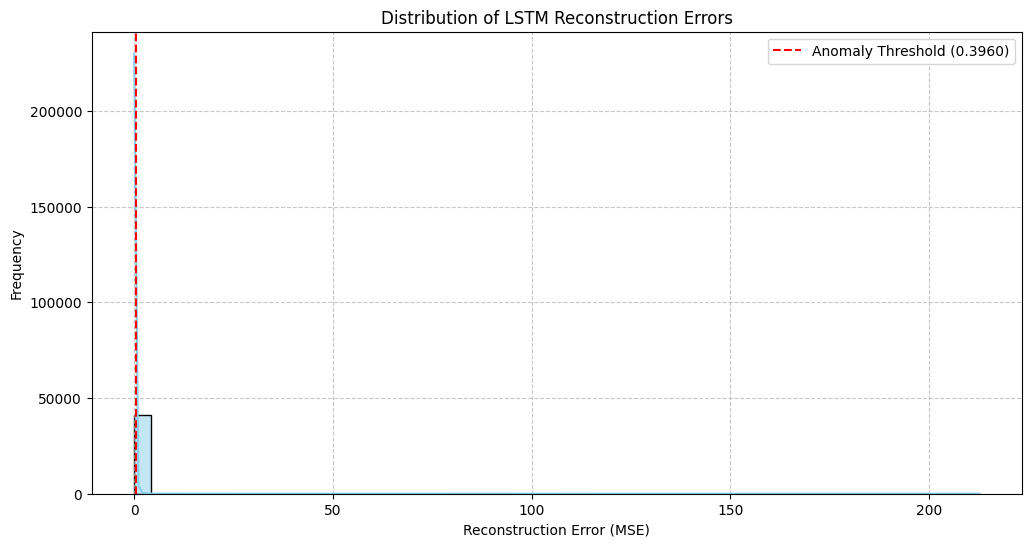


--- LSTM Anomaly Detection Complete ---

Head of full_lstm_results (merged with original data):
                      adj close        close         high          low         open      volume  reconstruction_error  is_anomaly
Date       Ticker                                                                                                               
2014-02-12 AZN     3987.271729  4002.500000  4008.500000  3956.500000  3989.500000   2830986.0              0.129761       False
           BARC     259.617554   260.450012   271.515991   259.750000   264.700012  58225865.0              0.146167       False
           BATS    2974.115723  2995.000000  3012.500000  2985.000000  3000.000000   3635252.0              0.096368       False
           BHP     1852.980347  1862.500000  1881.000000  1852.035034  1864.000000   7398187.0              0.070718       False
           BP       483.940948   487.049988   493.200012   486.000000   487.350006  25415556.0              0.063192       False

In [38]:
# --- Call the evaluate_and_detect_lstm_anomalies function ---
full_lstm_results, anomalies_lstm_df, threshold_lstm = evaluate_and_detect_lstm_anomalies(
    model=lstm100_autoencoder_model,
    X_train=X100_train,
    y_train=y100_train,
    X_val=X100_val,
    y_val=y100_val,
    X_test=X100_test,
    y_test=y100_test,
    sample_indices_all=sample100_indices_lstm,
    original_raw_data=ready_ftse100_data # Your actual ready_ftse100_data or ready_ftse250_data
)

print("\n--- LSTM Anomaly Detection Complete ---")
print("\nHead of full_lstm_results (merged with original data):\n", full_lstm_results.head())
print("\nHead of anomalies_lstm_df (only detected anomalies):\n", anomalies_lstm_df.head())
print(f"\nCalculated LSTM Anomaly Threshold: {threshold_lstm:.6f}")


In [ ]:
!

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Unsupervised_Anomaly_Detection.ipynb

no changes added to commit (use "git add" and/or "git commit -a")
